# 0. Install and Import Dependencies

In [1]:
import cv2
import mediapipe as mp
import numpy as np
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# 1. Make Detections

# 2. Determining Joints

<img src="https://i.imgur.com/3j8BPdc.png" style="height:300px" >

# 3. Calculate Angles

In [2]:
import numpy as np

def minvisibility(objs):
    return min([i.visibility for i in objs])

def obj_to_coord(obj):
    return [obj.x, obj.y, obj.z]

def vector_minus(v1, v2):
    return [v1[0] - v2[0], v1[1] - v2[1], v1[2] - v2[2]]

def get_angle(v1, v2):
    dot = v1[0] * v2[0] + v1[1] * v2[1] + v1[2] * v2[2]
    abs_v1 = np.sqrt(v1[0] * v1[0] + v1[1] * v1[1] + v1[2] * v1[2])
    abs_v2 = np.sqrt(v2[0] * v2[0] + v2[1] * v2[1] + v2[2] * v2[2])
    return np.arccos(min(dot / (abs_v1 * abs_v2), 1))

In [33]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

def minvisibility(objs):
    return min([i.visibility for i in objs])

def obj_to_coord(obj):
    return [obj.x, obj.y, obj.z]

def vector_minus(v1, v2):
    return [v1[0] - v2[0], v1[1] - v2[1], v1[2] - v2[2]]

def get_angle(v1, v2):
    dot = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    return np.arccos(np.clip(dot / (norm_v1 * norm_v2), -1.0, 1.0)) * (180 / np.pi)

class EMADictSmoothing:
    def __init__(self, window_size=5, alpha=0.3):
        self.window_size = window_size
        self.alpha = alpha
        self.reset()

    def reset(self):
        self.buffer = []

    def __call__(self, data_dict):
        self.buffer.append(data_dict.copy())
        
        while len(self.buffer) > self.window_size:
            self.buffer.pop(0)
        
        smoothed = {}
        for key in data_dict.keys():
            smoothed[key] = 0.0
            for i, entry in enumerate(reversed(self.buffer)):
                weight = self.alpha * (1 - self.alpha)**i
                smoothed[key] += entry.get(key, 0.0) * weight
        
        return smoothed
def logic(path):
    cap = cv2.VideoCapture(path)

    ema_smoother = EMADictSmoothing(window_size=5, alpha=0.3)

    knee_angles = []
    torso_angles = []
    hip_angles = []
    symmetry_scores = []
    alignment_scores = []
    rep_count = 0

    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, (640, 960))
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
        
            results = pose.process(image)
        
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            
            try:
                landmarks = results.pose_landmarks.landmark
                
                left_knee = landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value]
                right_knee = landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value]
                left_hip = landmarks[mp_pose.PoseLandmark.LEFT_HIP.value]
                right_hip = landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value]
                left_ankle = landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value]
                right_ankle = landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value]
                left_shoulder = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value]
                right_shoulder = landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value]
                
                lh_pos = obj_to_coord(left_hip)
                rh_pos = obj_to_coord(right_hip)
                lk_pos = obj_to_coord(left_knee)
                rk_pos = obj_to_coord(right_knee)
                la_pos = obj_to_coord(left_ankle)
                ra_pos = obj_to_coord(right_ankle)
                ls_pos = obj_to_coord(left_shoulder)
                rs_pos = obj_to_coord(right_shoulder)
                
                l_thigh_vec = vector_minus(lk_pos, lh_pos)
                r_thigh_vec = vector_minus(rk_pos, rh_pos)
                l_shin_vec = vector_minus(la_pos, lk_pos)
                r_shin_vec = vector_minus(ra_pos, rk_pos)
                
                l_torso_vec = vector_minus(lh_pos, ls_pos)
                r_torso_vec = vector_minus(rh_pos, rs_pos)
                
                l_hip_vec = vector_minus(lh_pos, ls_pos)
                r_hip_vec = vector_minus(rh_pos, rs_pos)
                
                l_knee_angle = get_angle(l_thigh_vec, l_shin_vec)
                r_knee_angle = get_angle(r_thigh_vec, r_shin_vec)
                l_torso_angle = get_angle(l_torso_vec, [0, 1, 0])  
                r_torso_angle = get_angle(r_torso_vec, [0, 1, 0])
                l_hip_angle = get_angle(l_thigh_vec, l_hip_vec)
                r_hip_angle = get_angle(r_thigh_vec, r_hip_vec)
                
                avg_knee_angle = (l_knee_angle + r_knee_angle) / 2
                avg_torso_angle = (l_torso_angle + r_torso_angle) / 2
                
                symmetry_score = abs(l_knee_angle - r_knee_angle) + abs(l_torso_angle - r_torso_angle)
                
                l_alignment = abs(la_pos[0] - lk_pos[0]) < 0.1  
                r_alignment = abs(ra_pos[0] - rk_pos[0]) < 0.1
                alignment_score = int(l_alignment and r_alignment)
                
                if minvisibility([left_knee, right_knee, left_hip, right_hip, left_ankle, right_ankle]) > 0.5:
                    knee_angles.append(avg_knee_angle)
                    torso_angles.append(avg_torso_angle)
                    hip_angles.append((l_hip_angle + r_hip_angle) / 2)
                    symmetry_scores.append(symmetry_score)
                    alignment_scores.append(alignment_score)

                    is_standing = 1 if (avg_knee_angle > 160 and avg_torso_angle < 30) else 0
                    

                    current_pose = {
                        "squat_down": 1 if (np.mean(knee_angles[-5:]) < 100) else 0,
                        "good_form": 1 if (
                            np.mean(torso_angles[-5:]) < 50 and 
                            np.mean(knee_angles[-5:]) < 100 and  
                            alignment_score == 1 and             
                            symmetry_score < 50                 
                        ) else 0,
                        "standing": is_standing 
                    }
                    
                    smoothed_pose = ema_smoother(current_pose)
                    if smoothed_pose["squat_down"] >= 0.5 and rep_count % 2 == 0:
                        rep_count += 1
                    elif smoothed_pose["squat_down"] < 0.5 and rep_count % 2 == 1:
                        rep_count += 1
                    
                    cv2.putText(image, f"Reps: {rep_count//2}", (10, 30),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                    
                    if smoothed_pose["squat_down"] >= 0.5:
                        if smoothed_pose["good_form"] >= 0.5:
                            cv2.putText(image, "GOOD SQUAT!", (10, 60),
                                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                        else:
                            cv2.putText(image, "BAD FORM!", (10, 60),
                                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                    else:
                        cv2.putText(image, "Standing", (10, 60),
                                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)
            
            except Exception as e:
                print(f"Error: {e}")
                pass
            
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                    mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2), 
                                    mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))
            
            # cv2.imshow('Mediapipe Feed', image)
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()


    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(knee_angles, label='Knee Angle (°)')
    plt.axhline(y=100, color='r', linestyle='--', label='Depth Threshold')
    plt.title('Knee Flexion Angle')
    plt.xlabel('Frame')
    plt.ylabel('Angle (°)')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(torso_angles, label='Torso Angle (°)')
    plt.axhline(y=50, color='r', linestyle='--', label='Upright Threshold')
    plt.title('Torso Inclination')
    plt.xlabel('Frame')
    plt.ylabel('Angle (°)')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(symmetry_scores, label='Symmetry Score', color='green')
    plt.axhline(y=10, color='g', linestyle='--', label='Symmetry Tolerance')
    plt.plot(alignment_scores, label='Alignment Score', color='blue')
    plt.axhline(y=0.5, color='b', linestyle='--', label='Alignment Tolerance')
    plt.title('Form Metrics')
    plt.xlabel('Frame')
    plt.ylabel('Score')
    plt.legend()

    plt.tight_layout()
    plt.show()
    print(rep_count//2)
    return rep_count//2


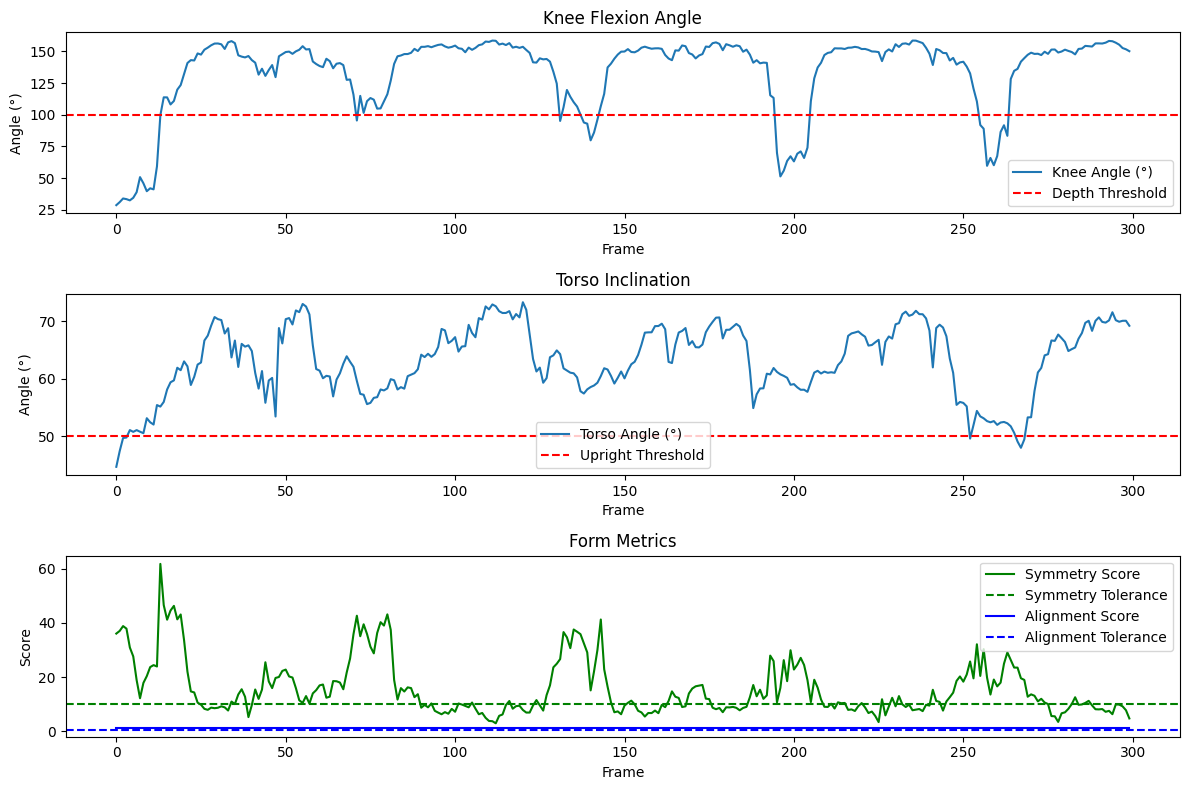

4
Video 1: 4 reps


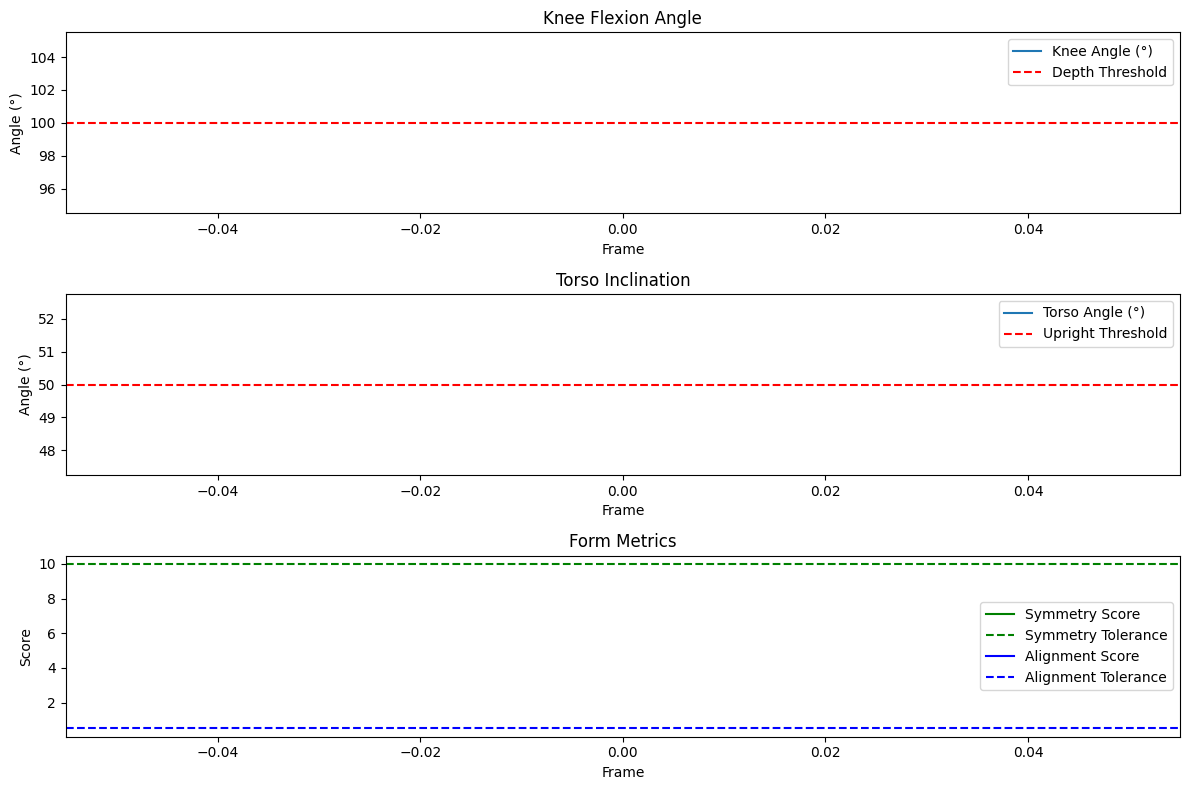

0
Video 2: 0 reps


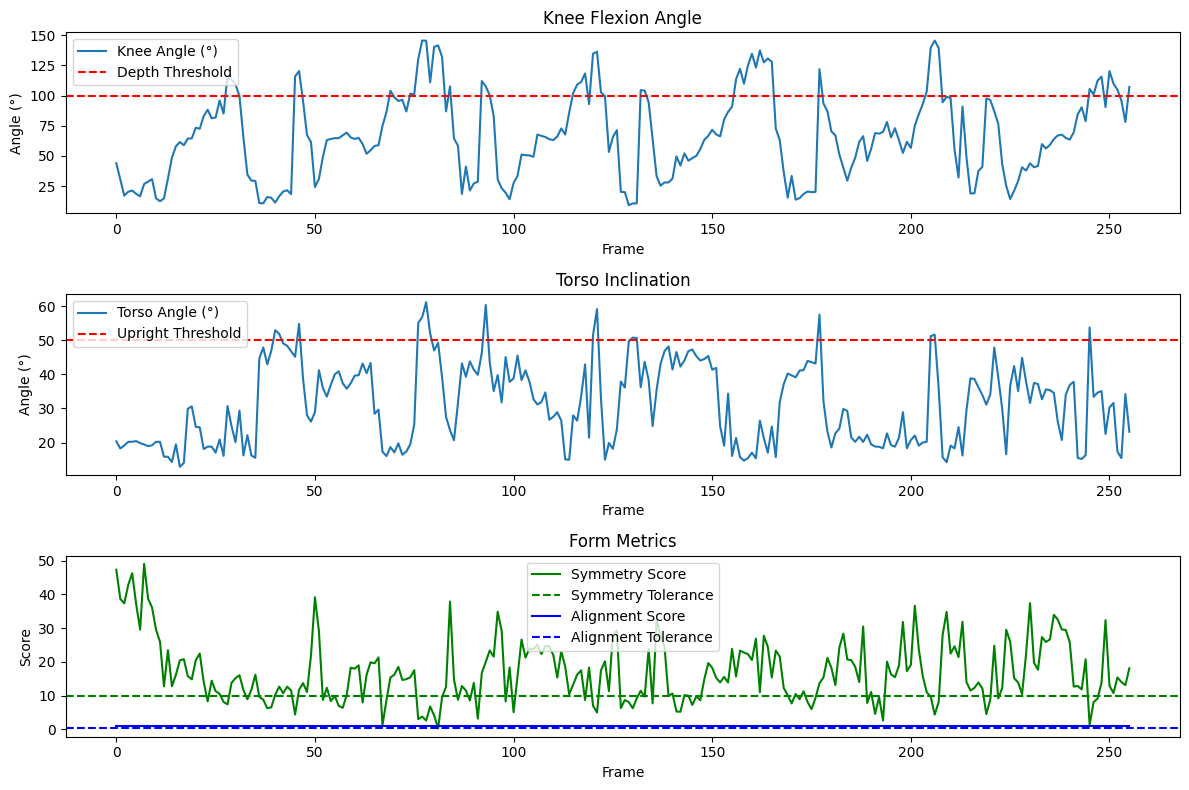

6
Video 3: 6 reps


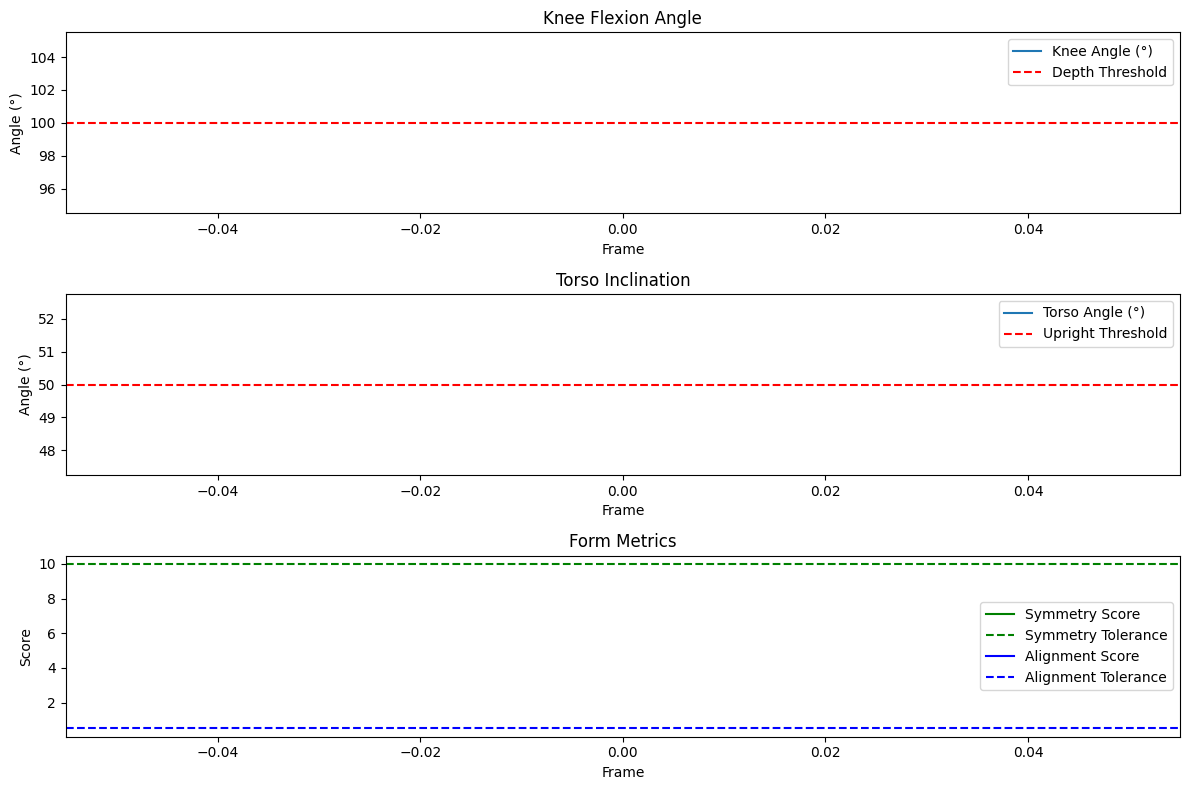

0
Video 4: 0 reps


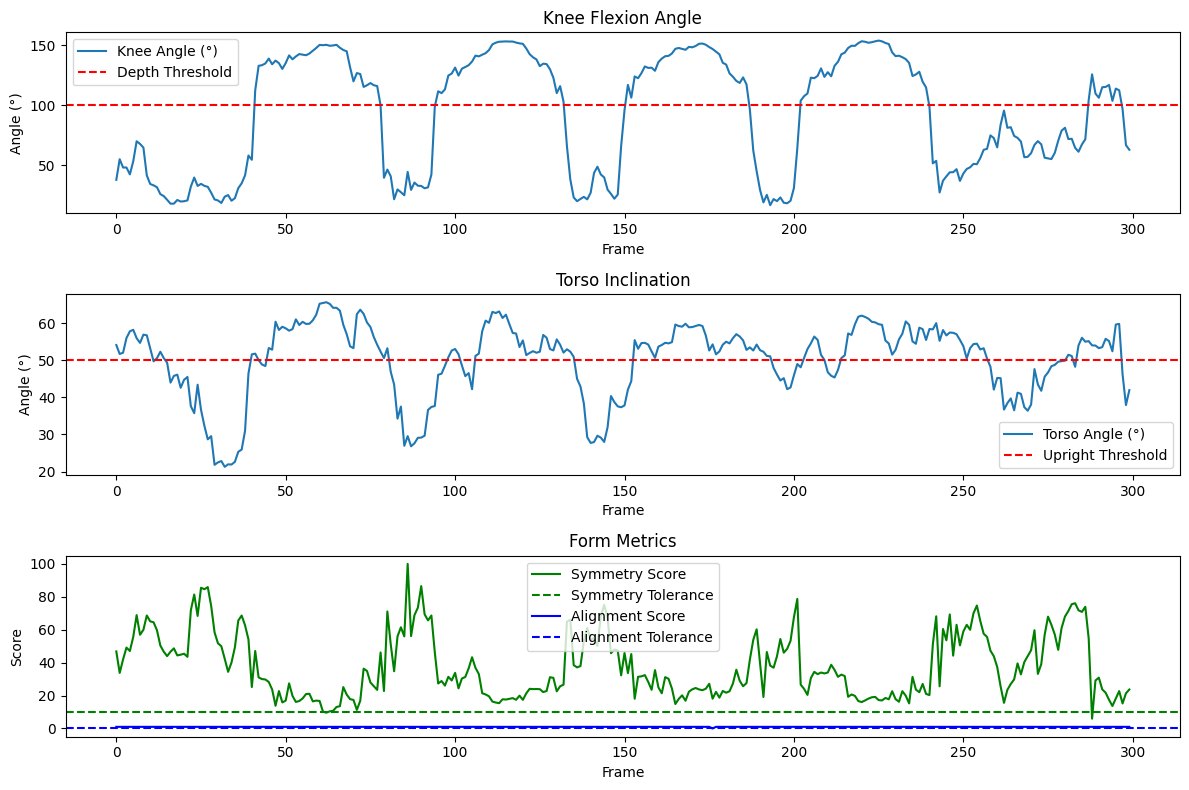

5
Video 5: 5 reps


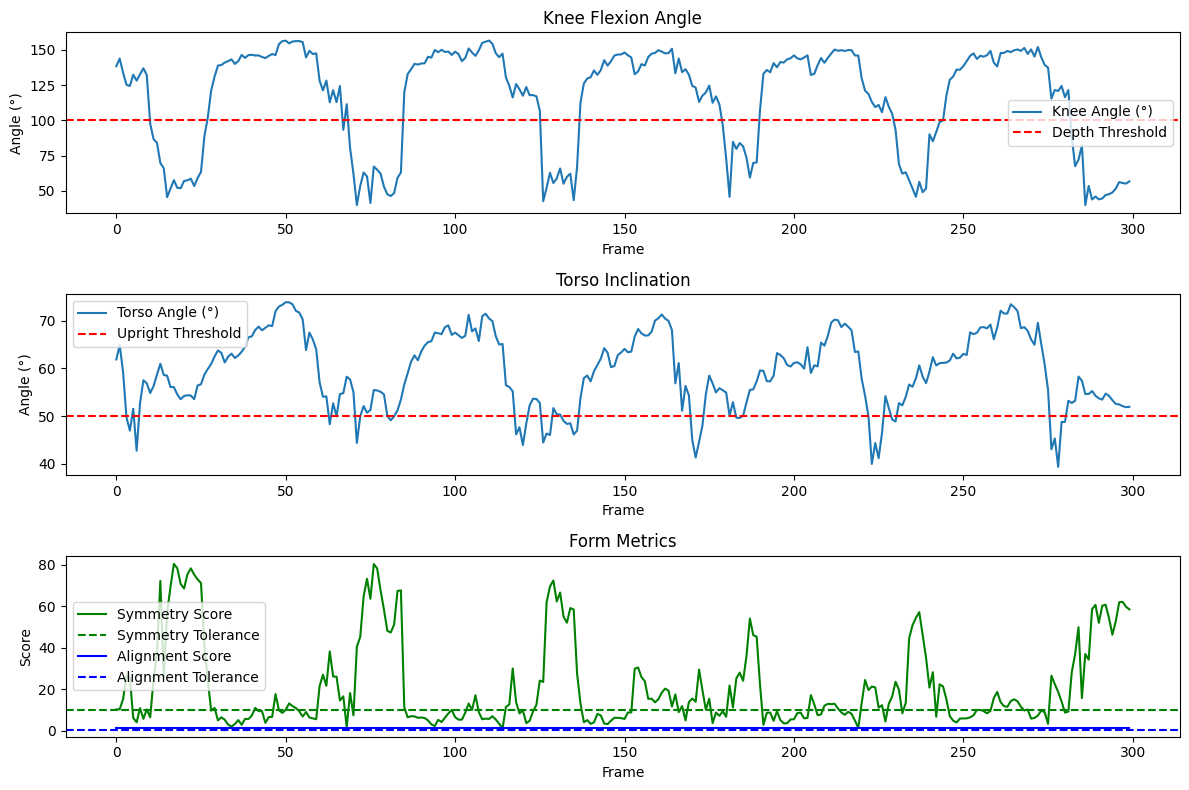

5
Video 6: 5 reps


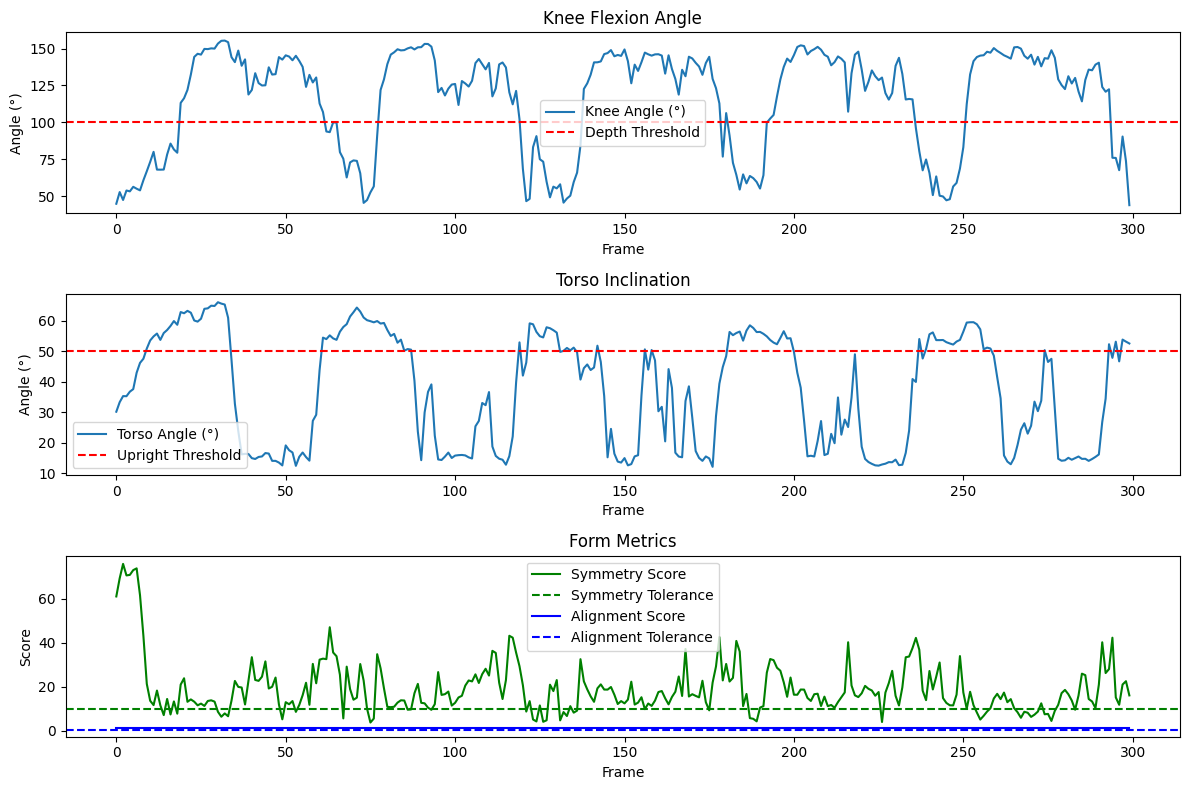

5
Video 7: 5 reps


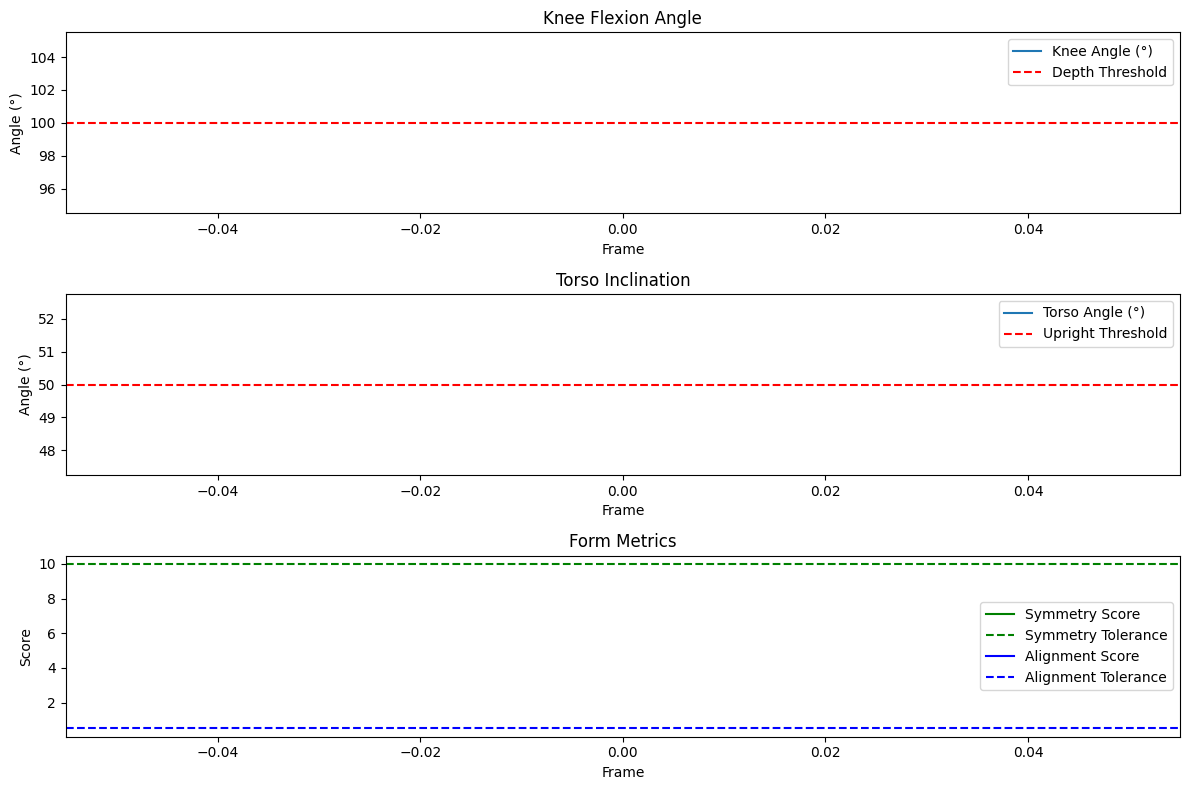

0
Video 8: 0 reps


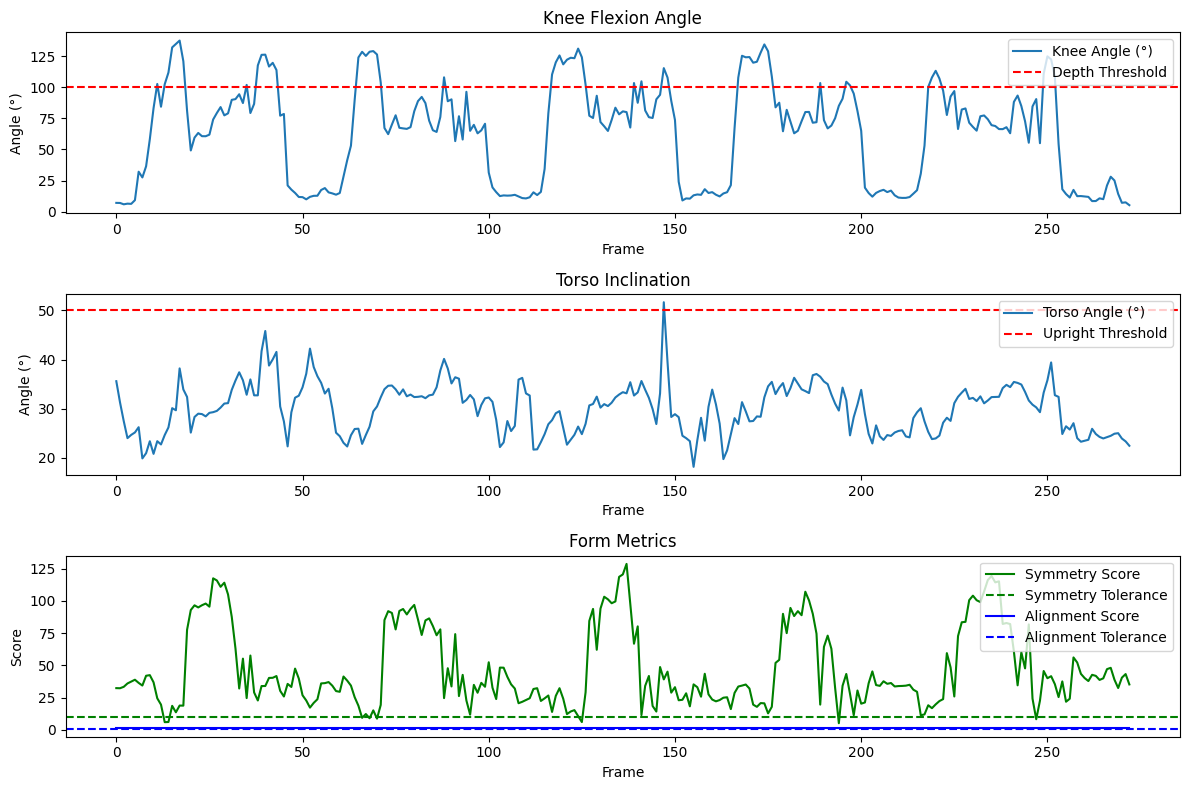

7
Video 9: 7 reps


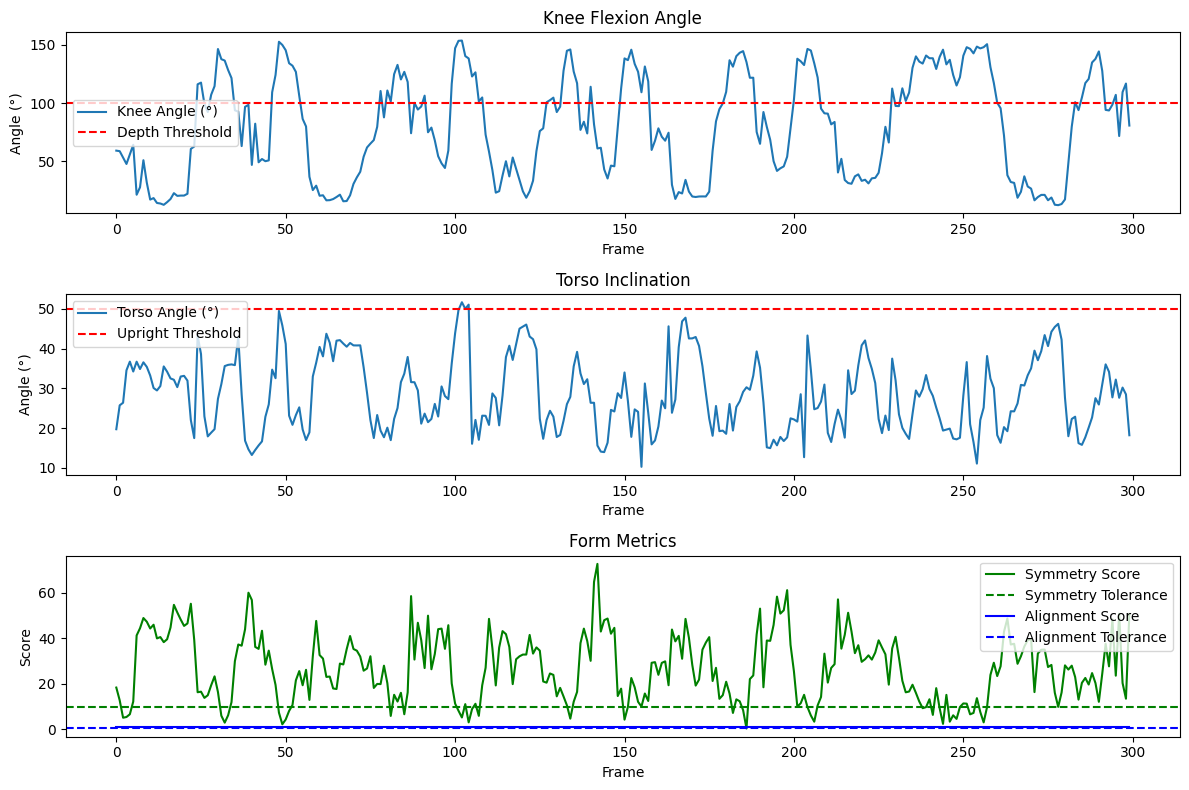

11
Video 10: 11 reps


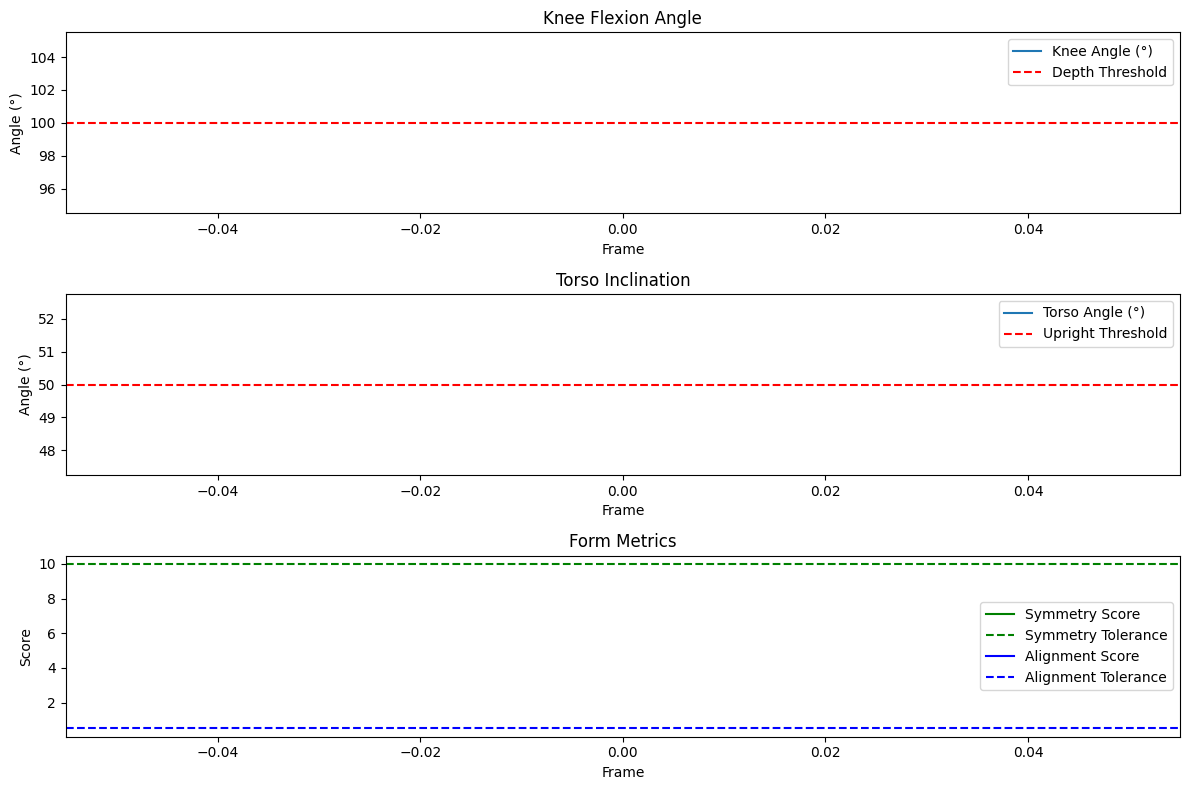

0
Video 11: 0 reps


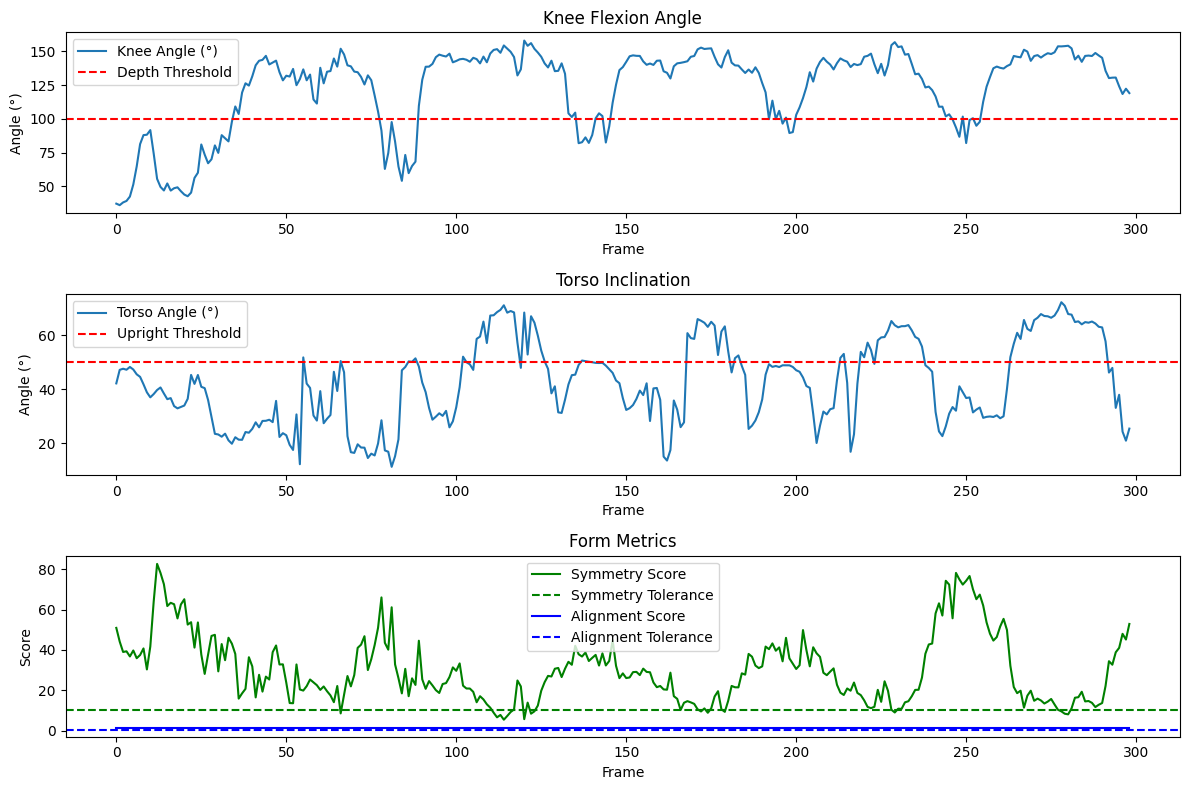

5
Video 12: 5 reps


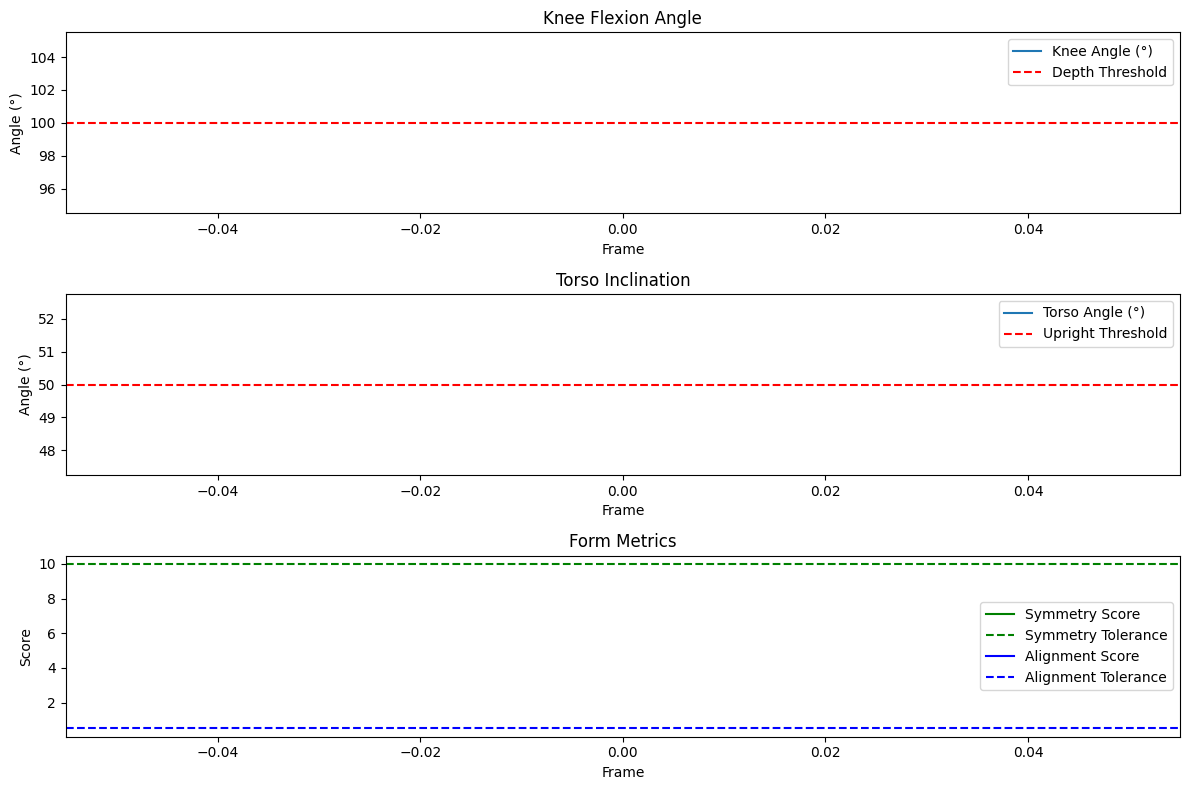

0
Video 13: 0 reps


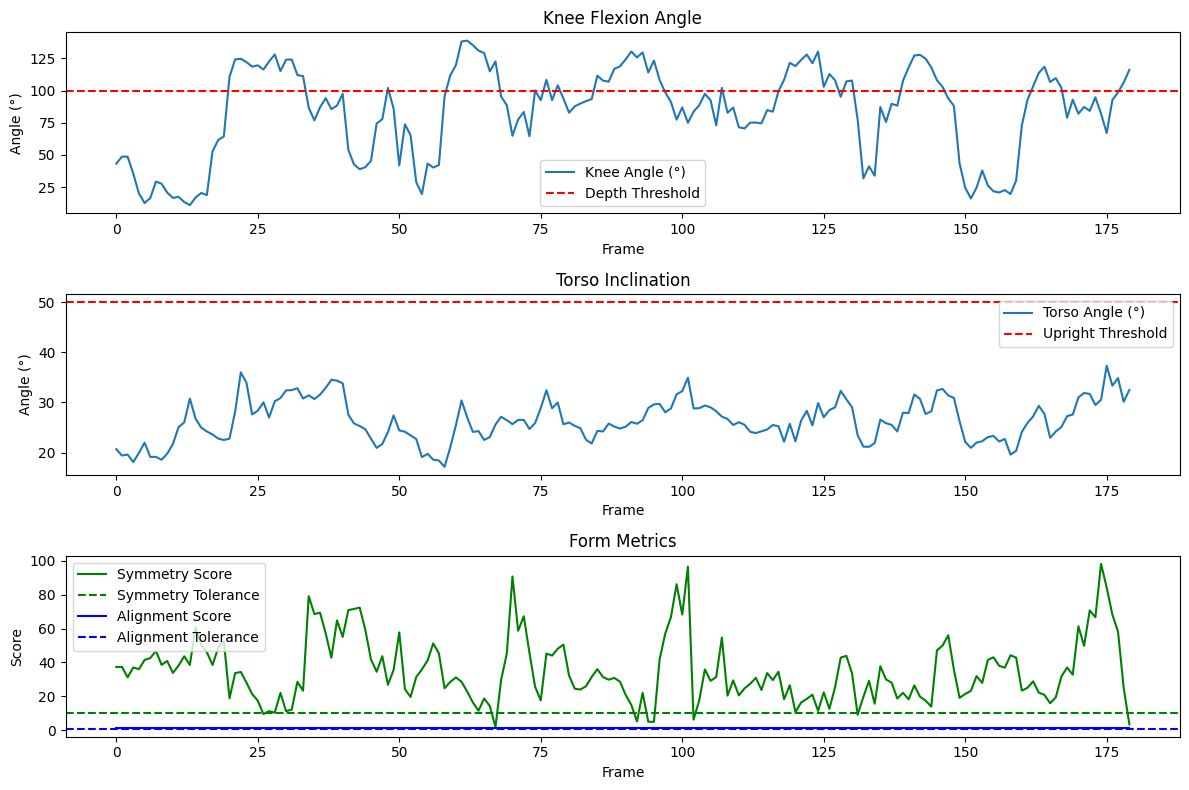

6
Video 14: 6 reps


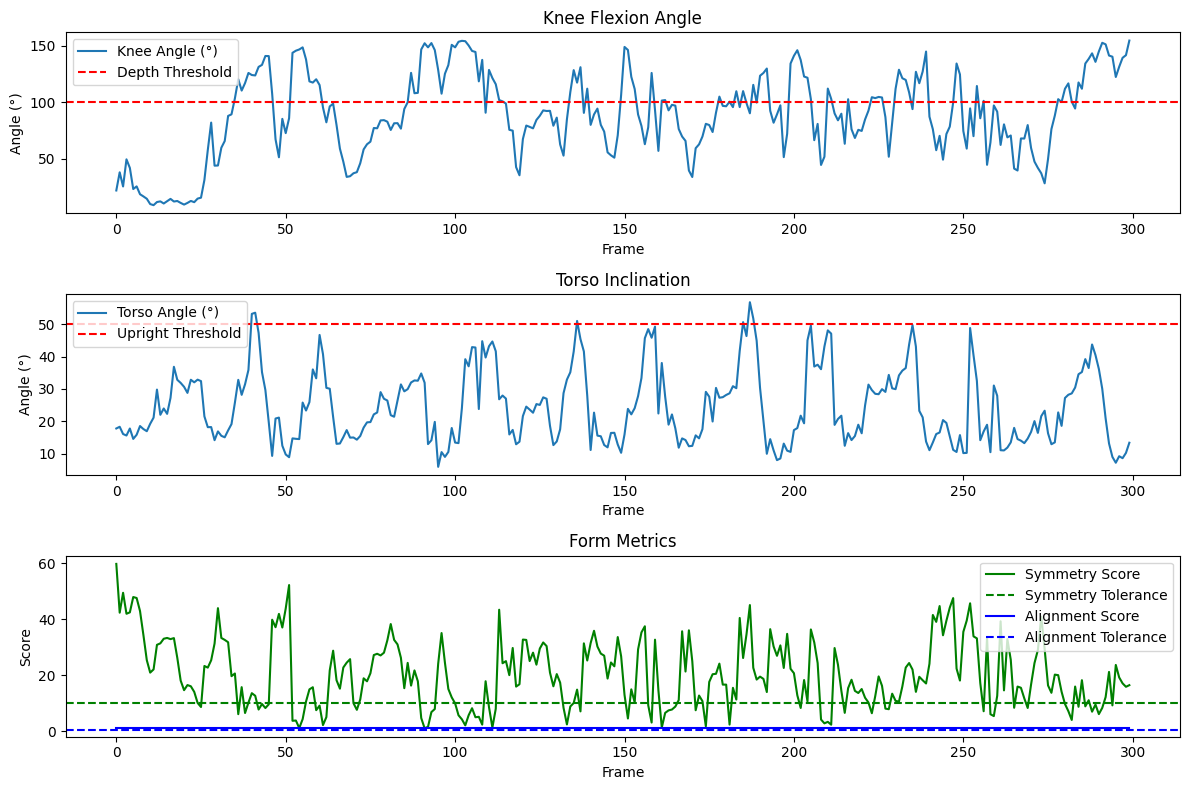

11
Video 15: 11 reps


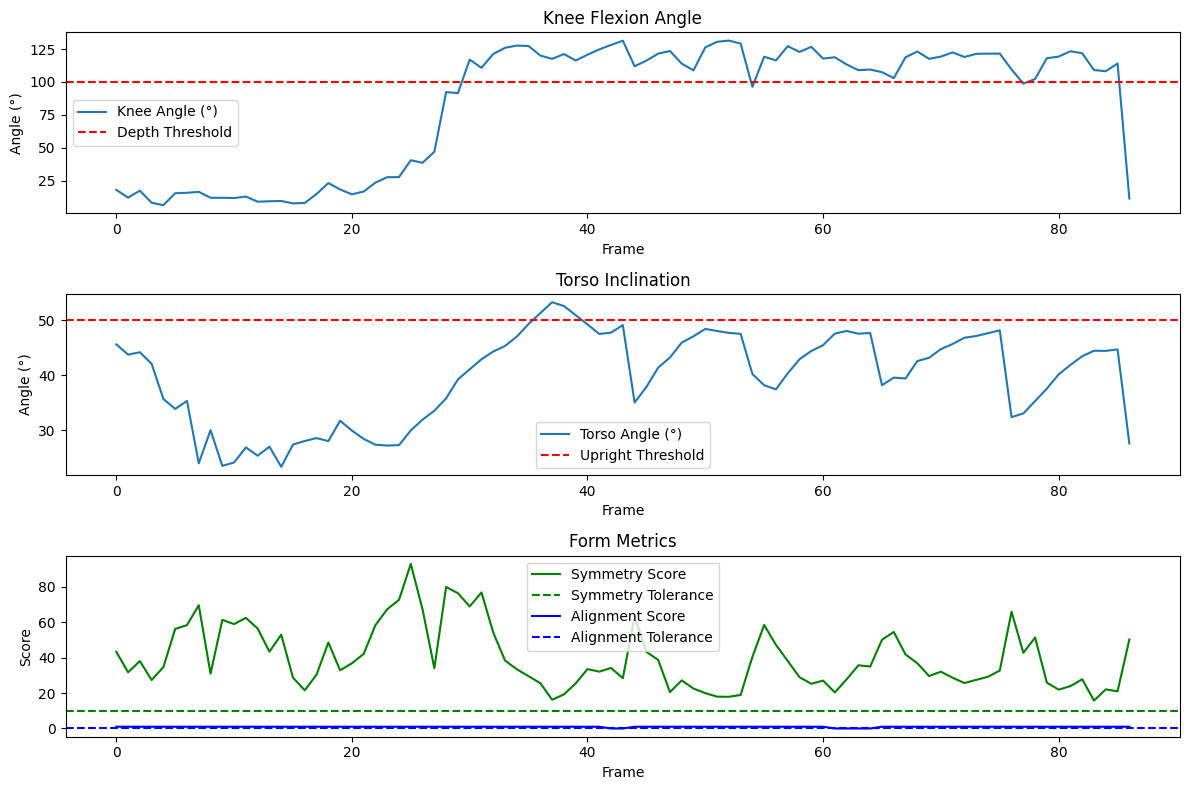

1
Video 16: 1 reps


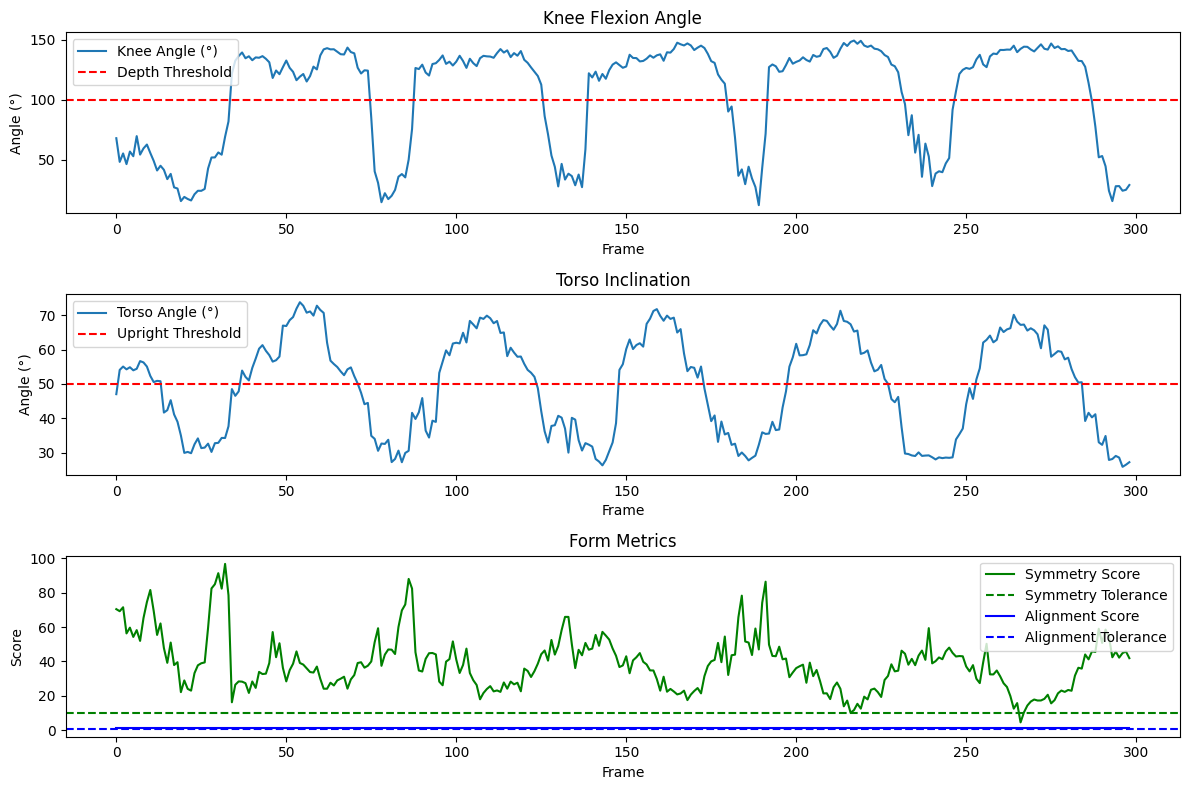

5
Video 17: 5 reps


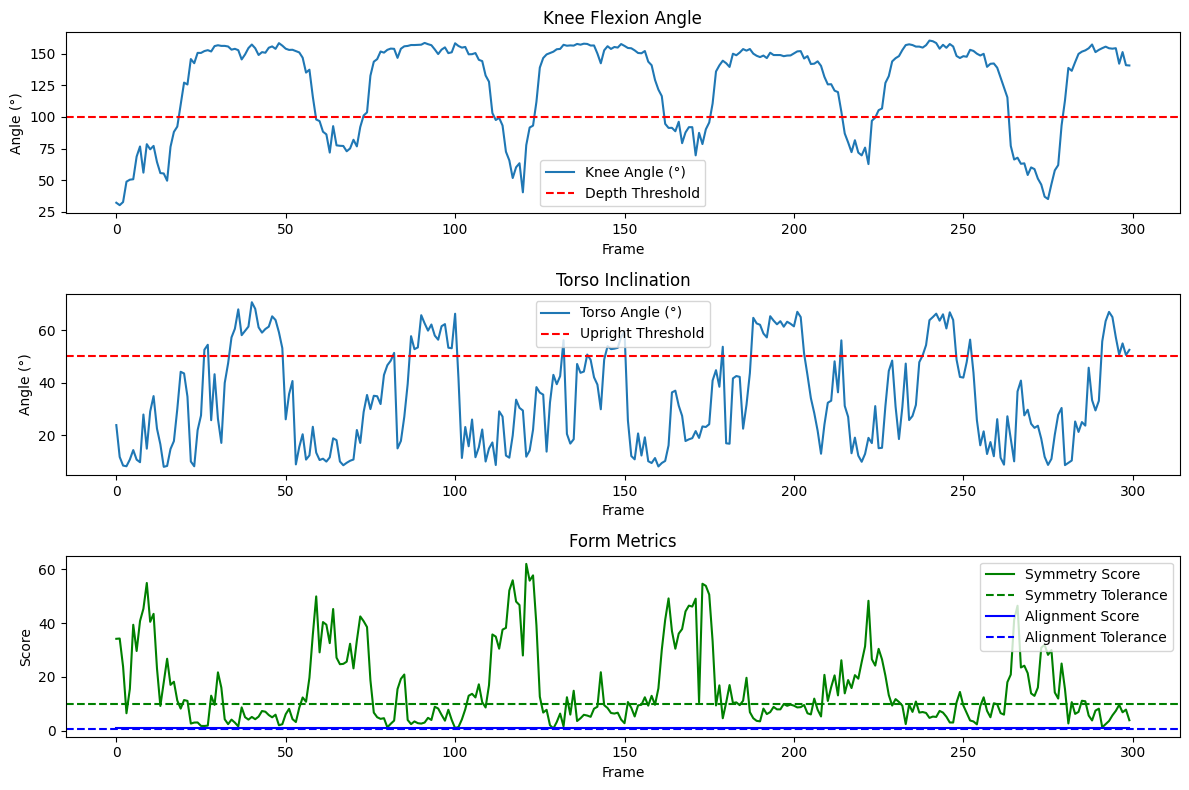

6
Video 18: 6 reps


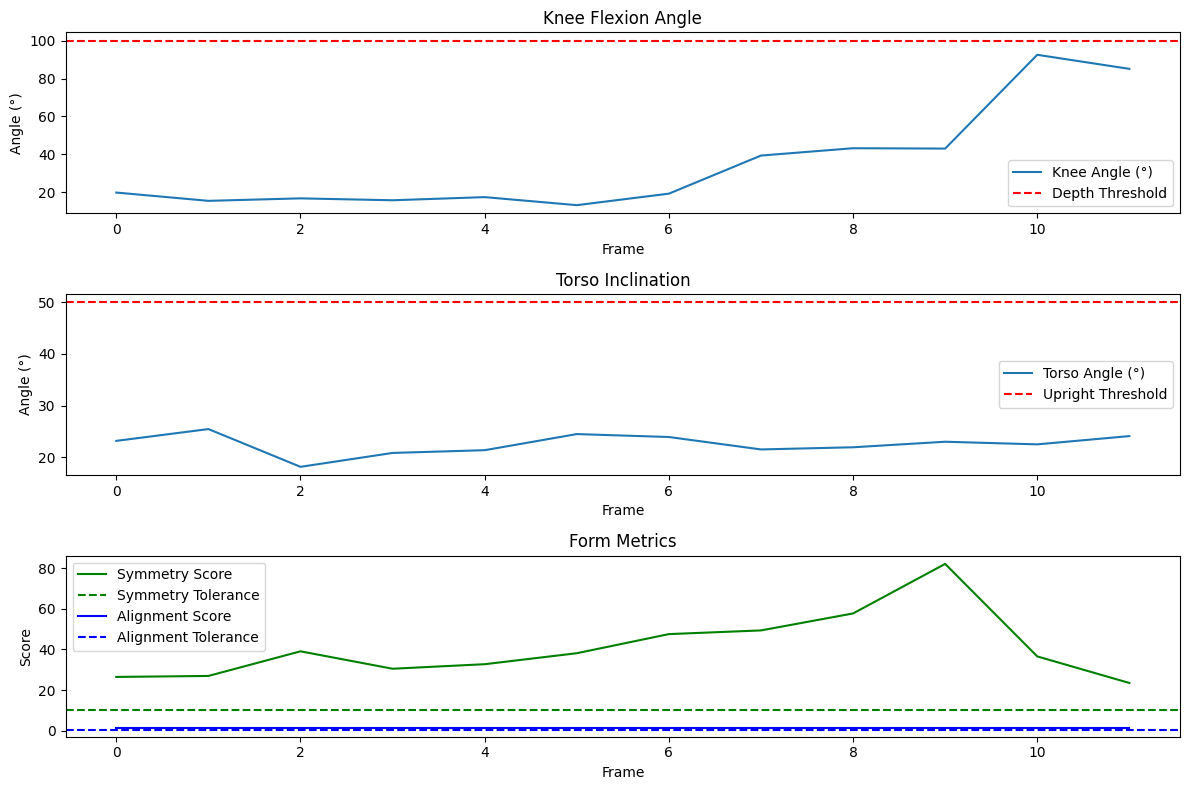

0
Video 19: 0 reps


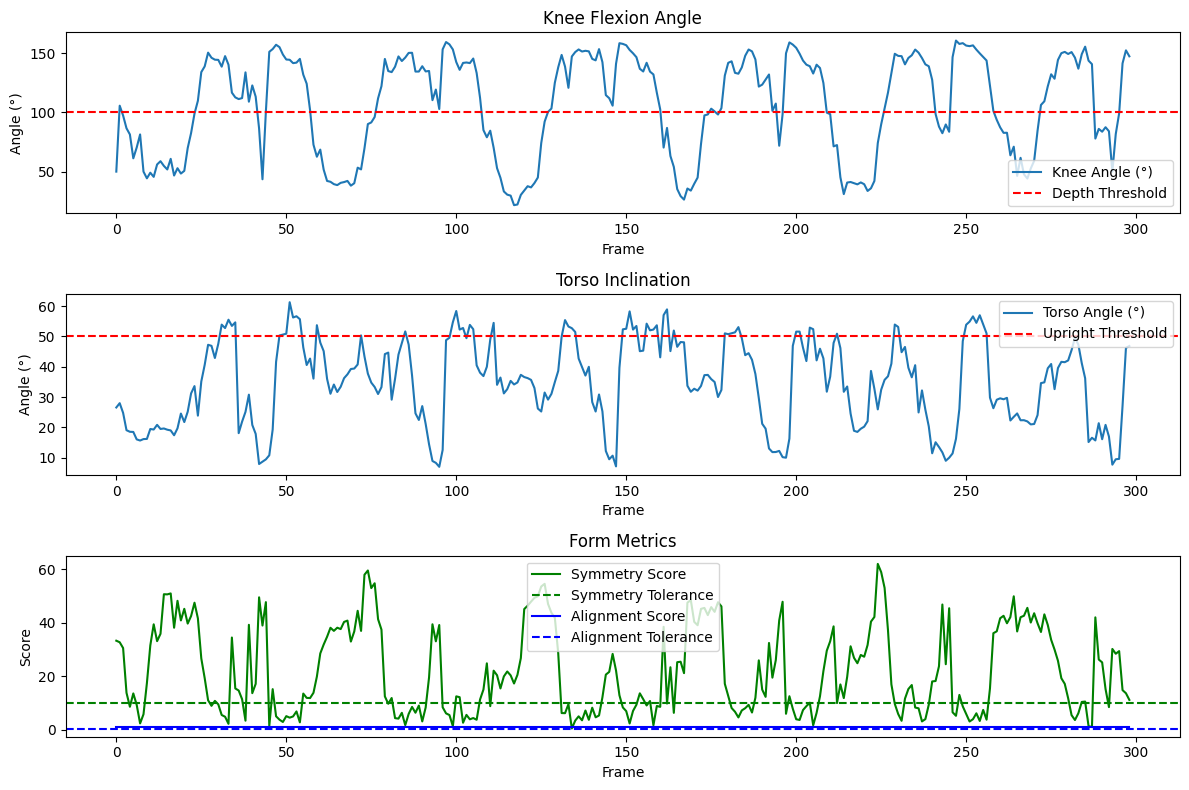

9
Video 20: 9 reps


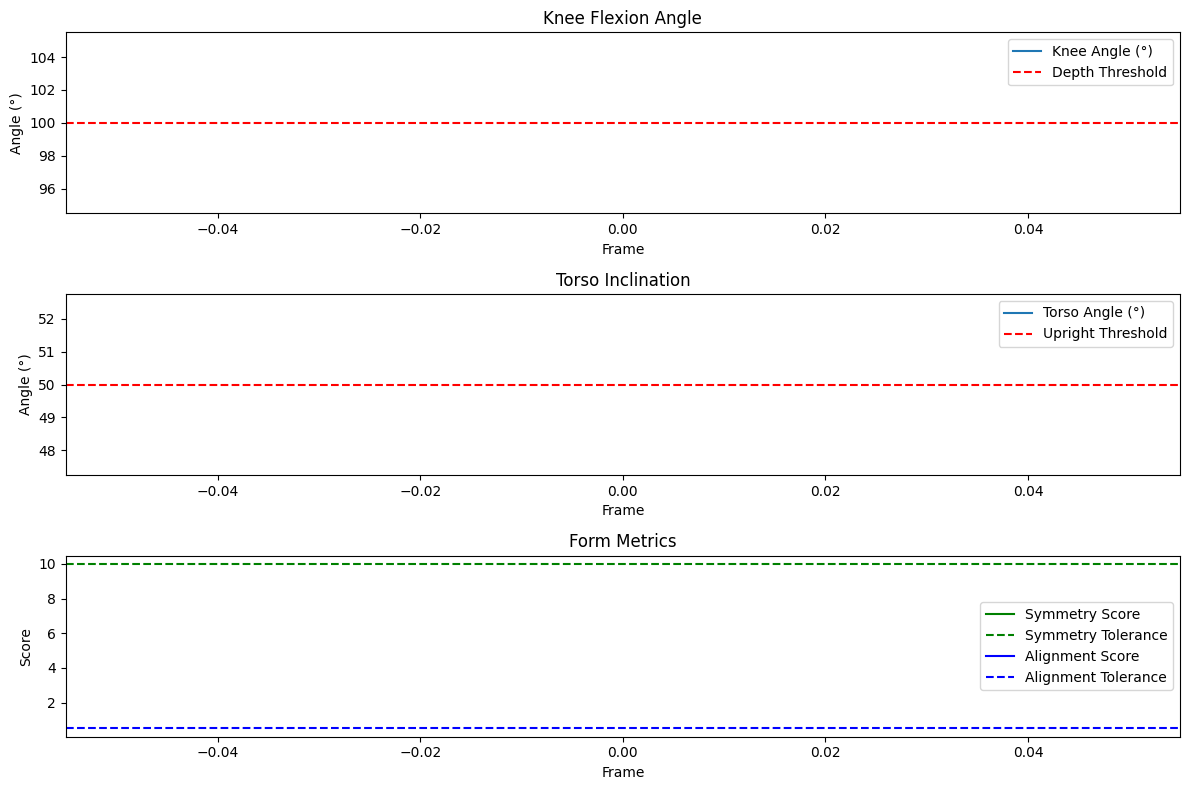

0
Video 21: 0 reps


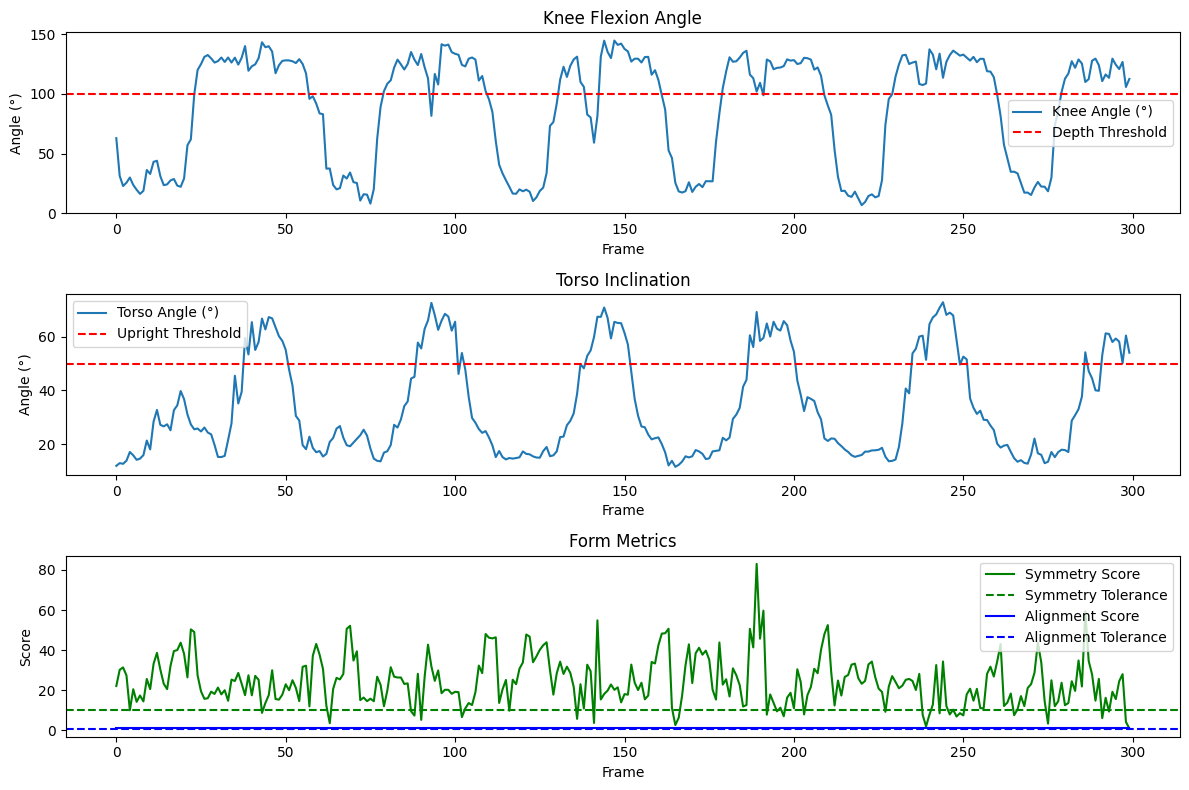

7
Video 22: 7 reps


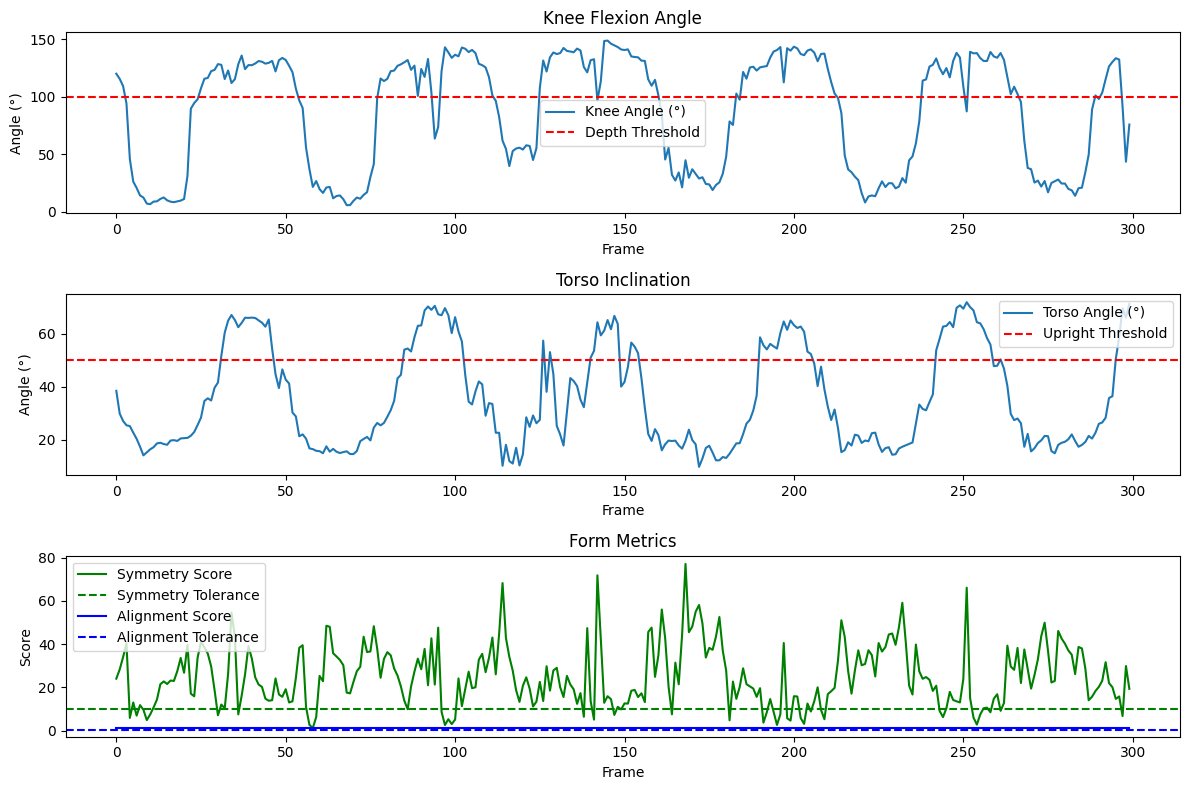

7
Video 23: 7 reps


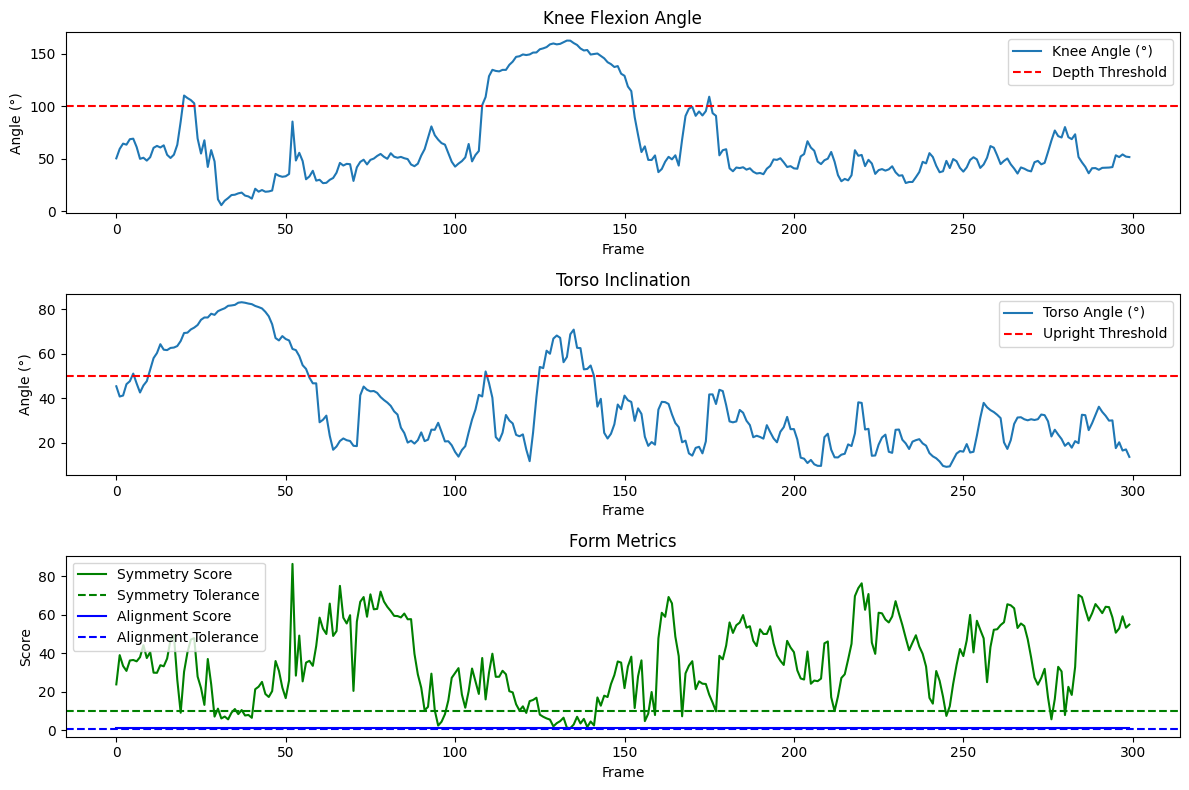

1
Video 24: 1 reps


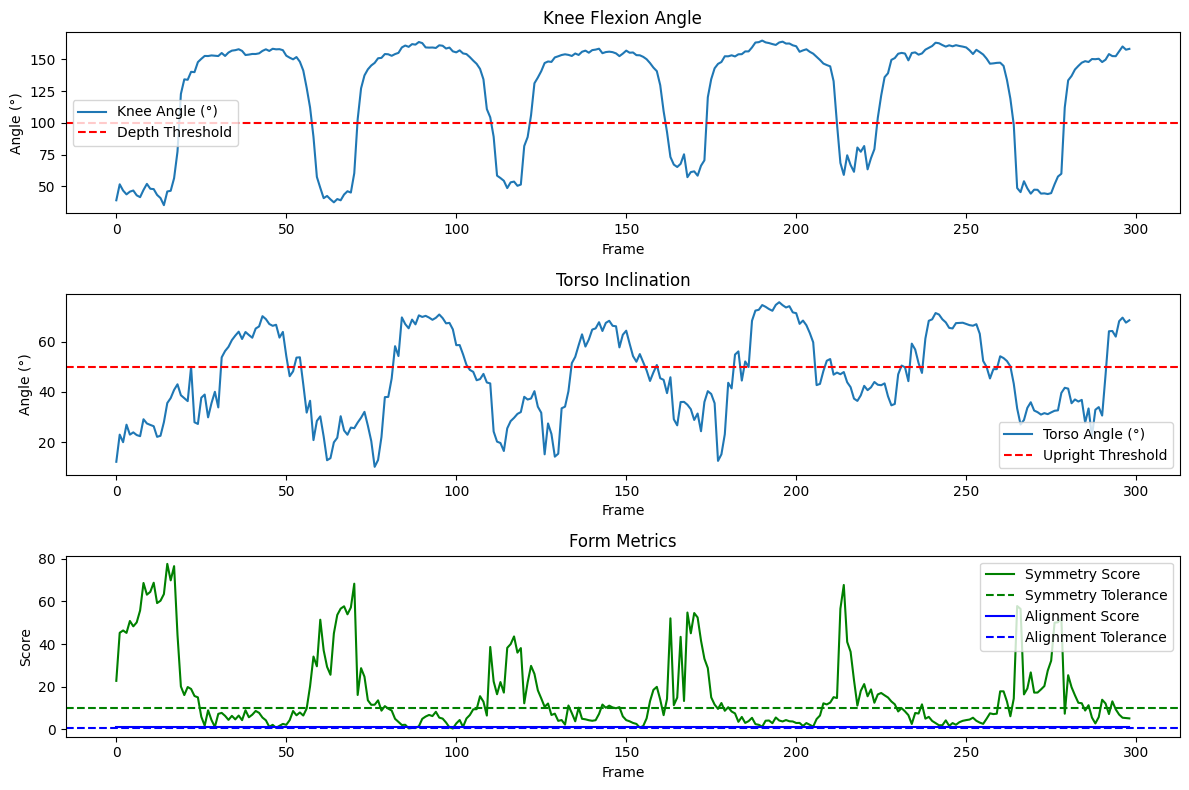

6
Video 25: 6 reps


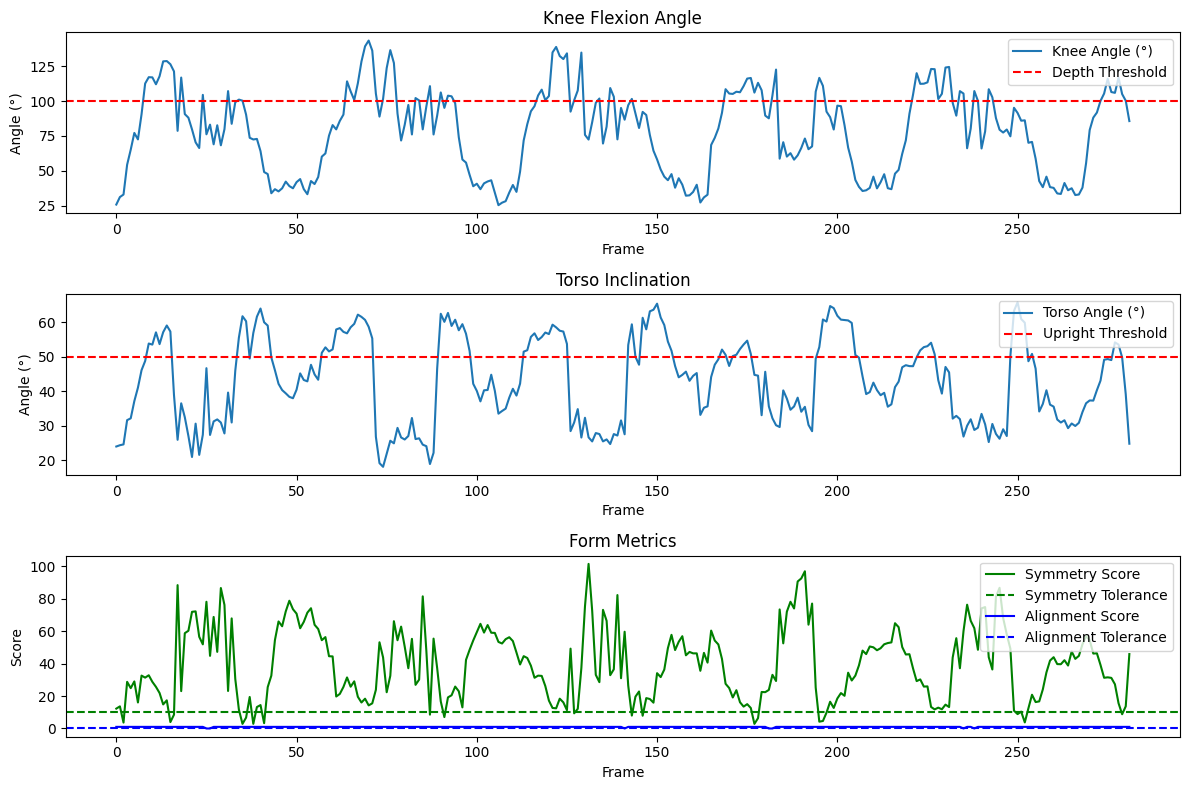

6
Video 26: 6 reps


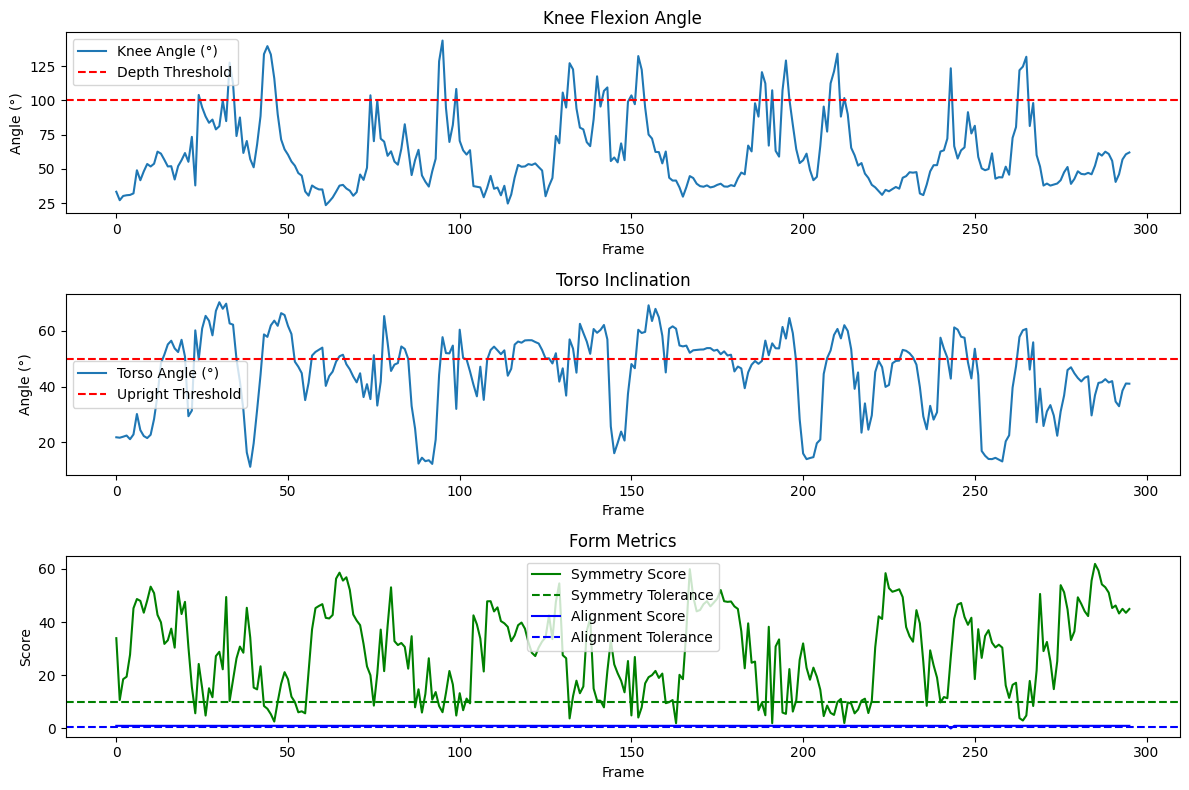

5
Video 27: 5 reps


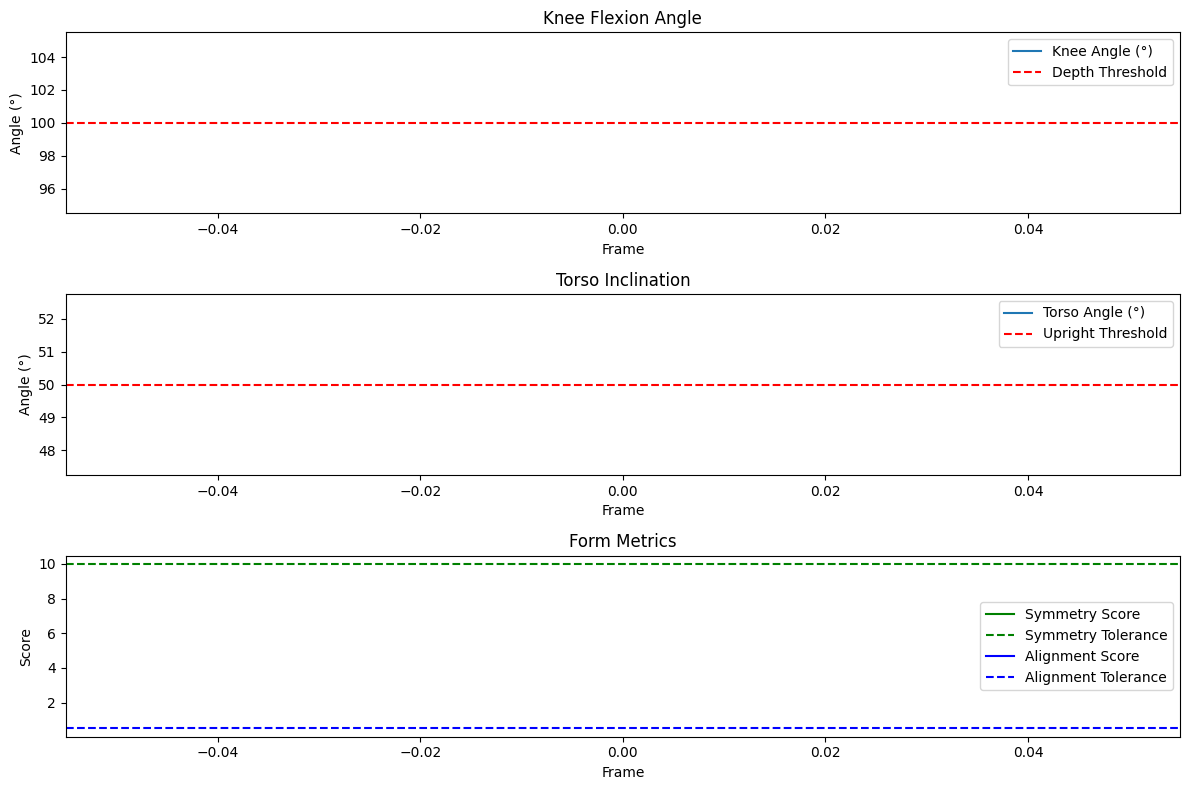

0
Video 28: 0 reps


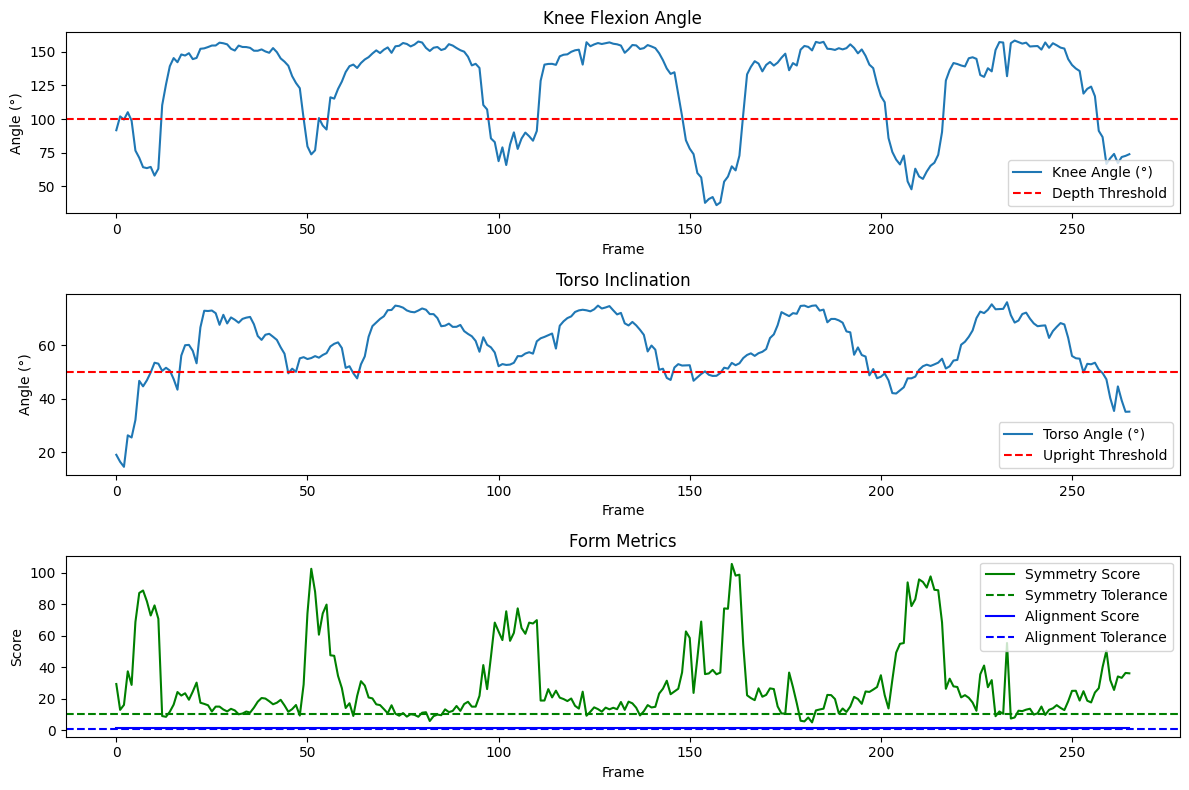

5
Video 29: 5 reps


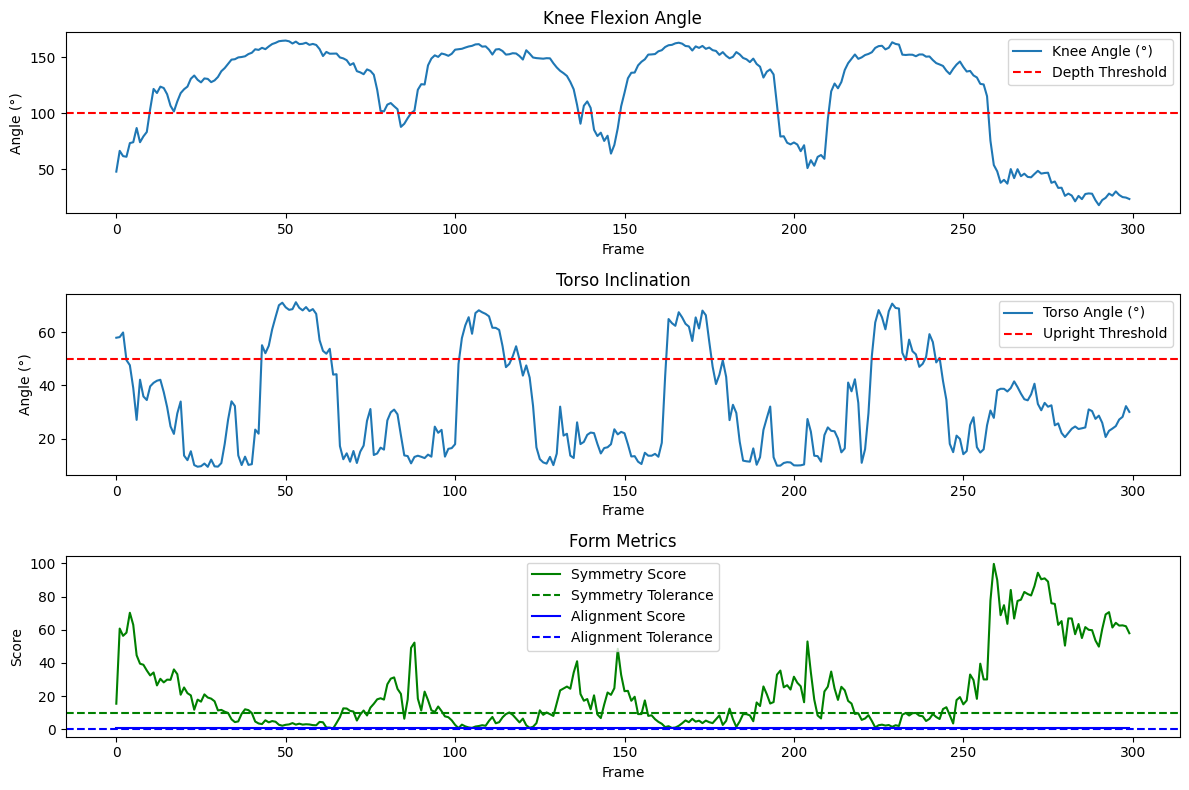

4
Video 30: 4 reps


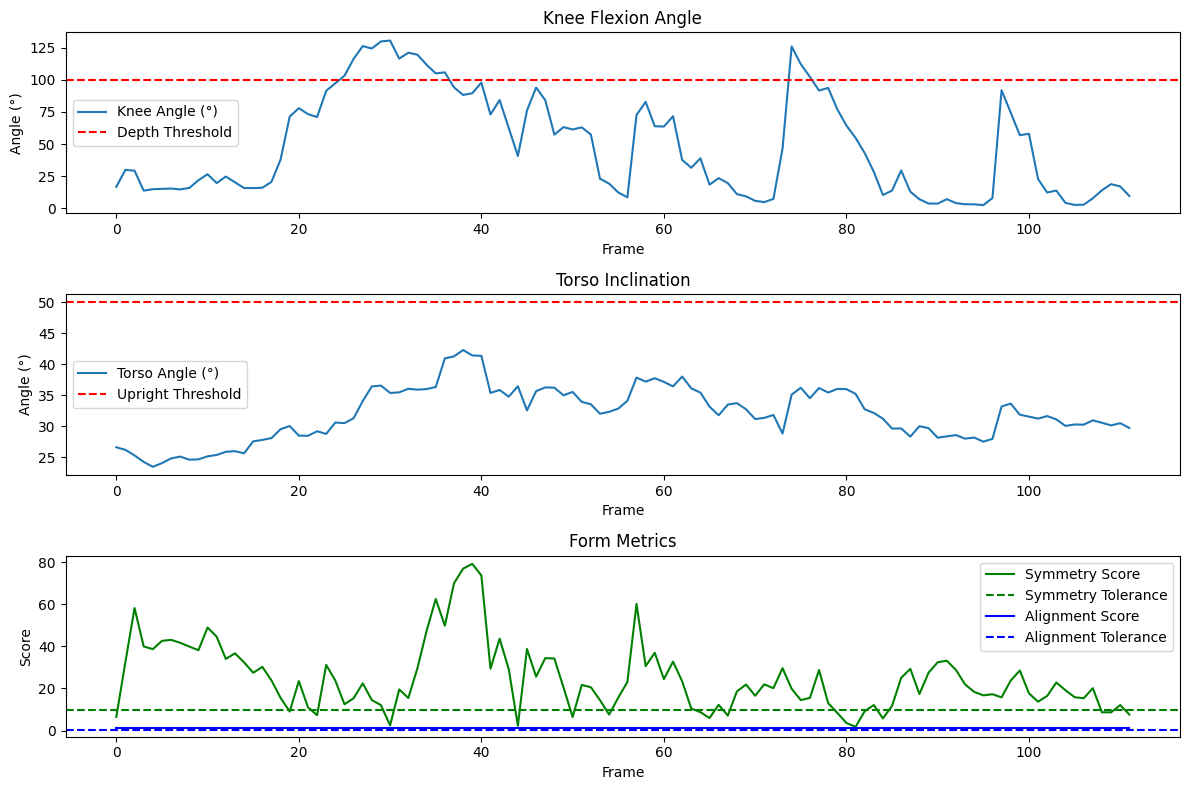

1
Video 31: 1 reps


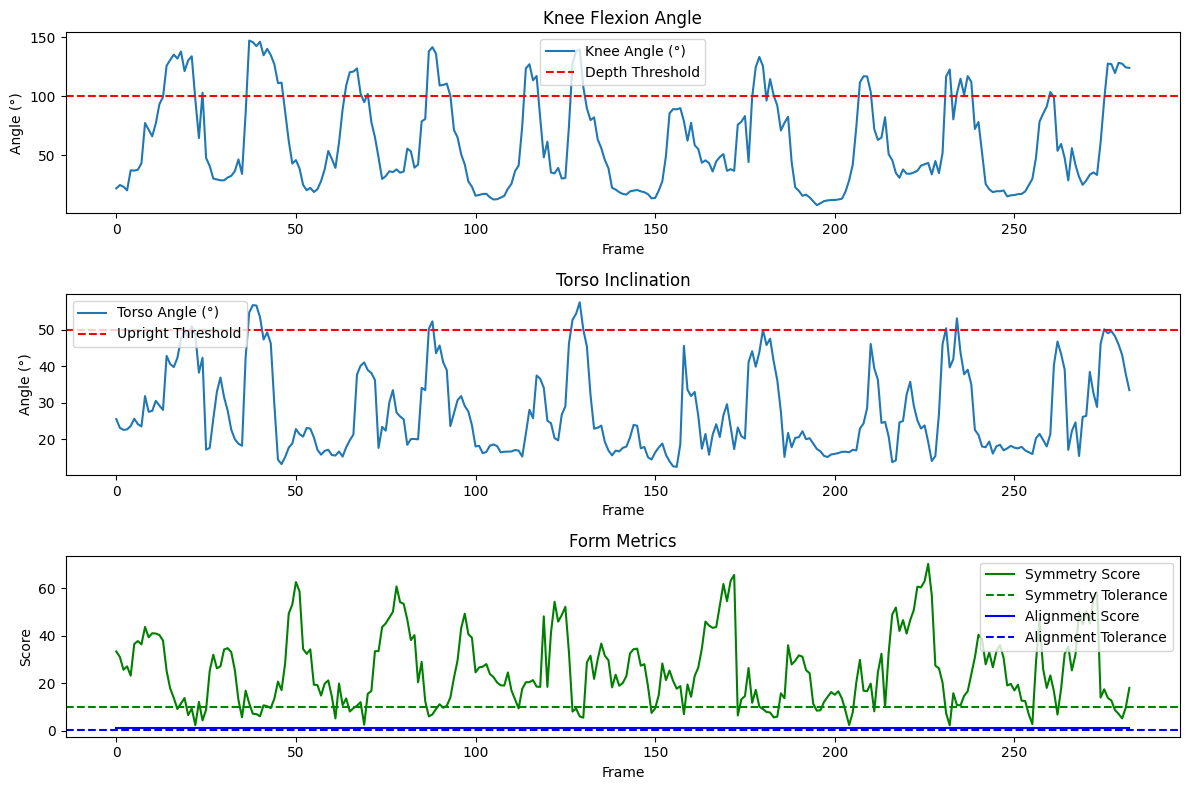

10
Video 32: 10 reps


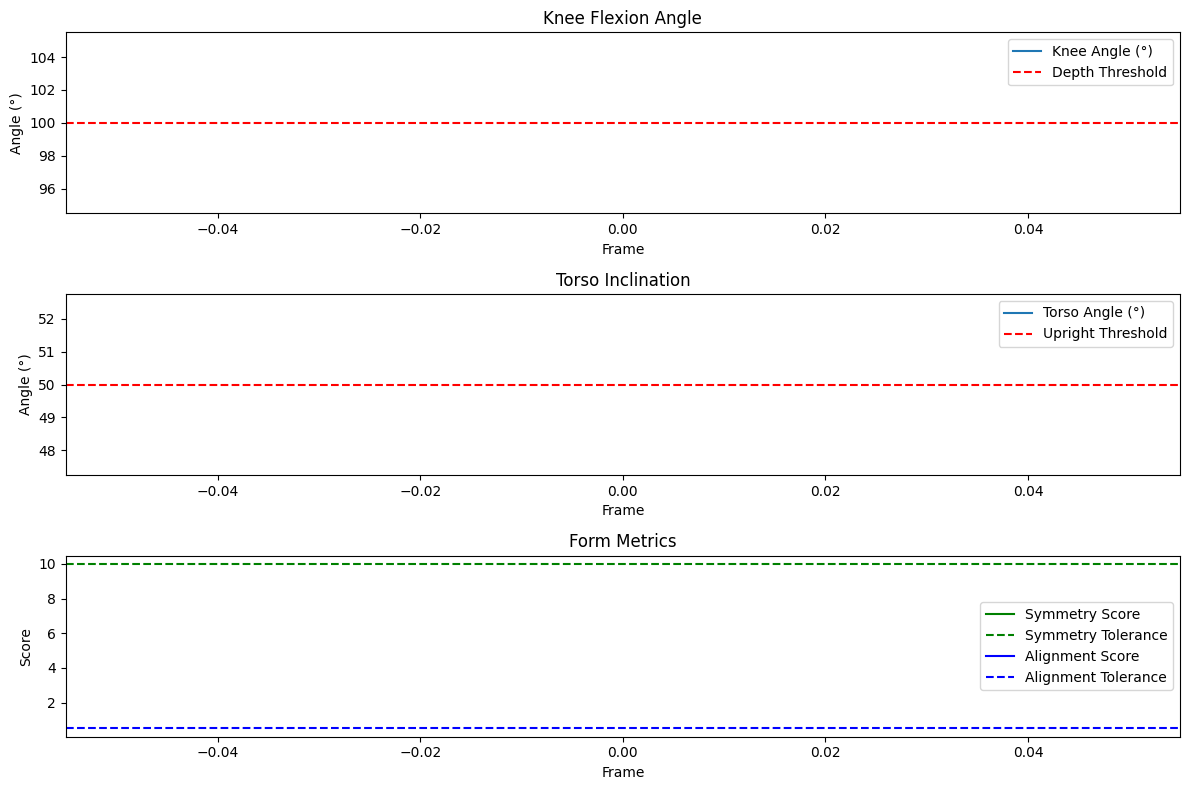

0
Video 33: 0 reps


In [37]:
import os
dataset='Video_Dataset/Video_Dataset/good/1115_video'
videos=os.listdir(dataset)
videos=[os.path.join(dataset,i) for i in videos if i.startswith('clean_squat')]
reps_each=[]
for i in range(len(videos)):
    reps=logic(videos[i])
    print(f"Video {i+1}: {reps} reps")
    reps_each.append(reps)

In [38]:
print(reps_each)
reps_each_set=[]
for i in reps_each:
    if i>=5:
        reps_each_set.append(1)
    else:
        reps_each_set.append(0)
print(reps_each_set)

[4, 0, 6, 0, 5, 5, 5, 0, 7, 11, 0, 5, 0, 6, 11, 1, 5, 6, 0, 9, 0, 7, 7, 1, 6, 6, 5, 0, 5, 4, 1, 10, 0]
[0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0]


In [39]:
print("Accuracy:", sum(reps_each_set)/len(reps_each_set))

Accuracy: 0.5757575757575758


In [ ]:
# Add this function to calculate precision and recall
def calculate_metrics(predicted_reps, actual_reps):
    """
    Calculate precision and recall for squat detection
    
    Args:
        predicted_reps: Number of squats detected by the model
        actual_reps: Ground truth number of squats
    
    Returns:
        precision: TP / (TP + FP)
        recall: TP / (TP + FN)
    """
    if predicted_reps == 0 and actual_reps == 0:
        return 1.0, 1.0
    elif predicted_reps == 0:
        return 0.0, 0.0

    tp = min(predicted_reps, actual_reps)

    fp = max(0, predicted_reps - actual_reps)

    fn = max(0, actual_reps - predicted_reps)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    return precision, recall

import os
dataset='Video_Dataset/Video_Dataset/good/1115_video'
videos=os.listdir(dataset)
videos=[os.path.join(dataset,i) for i in videos if i.startswith('clean_squat')]
metrics = []

ground_truth_reps = [6 for i in range(len(videos))] 

for i in range(len(videos)):
    predicted_reps = reps_each[i]  
    actual_reps = ground_truth_reps[i]
    
    precision, recall = calculate_metrics(predicted_reps, actual_reps)
    metrics.append({
        'video': i+1,
        'predicted': predicted_reps,
        'actual': actual_reps,
        'precision': precision,
        'recall': recall
    })
    print(f"Video {i+1}:")
    print(f"Predicted reps: {predicted_reps}")
    print(f"Actual reps: {actual_reps}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}\n")

# Calculate average metrics
avg_precision = np.mean([m['precision'] for m in metrics])
avg_recall = np.mean([m['recall'] for m in metrics])
f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)

print(f"Average Precision: {avg_precision:.2f}")
print(f"Average Recall: {avg_recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

Video 1:
Predicted reps: 4
Actual reps: 6
Precision: 1.00
Recall: 0.67

Video 2:
Predicted reps: 0
Actual reps: 6
Precision: 0.00
Recall: 0.00

Video 3:
Predicted reps: 6
Actual reps: 6
Precision: 1.00
Recall: 1.00

Video 4:
Predicted reps: 0
Actual reps: 6
Precision: 0.00
Recall: 0.00

Video 5:
Predicted reps: 5
Actual reps: 6
Precision: 1.00
Recall: 0.83

Video 6:
Predicted reps: 5
Actual reps: 6
Precision: 1.00
Recall: 0.83

Video 7:
Predicted reps: 5
Actual reps: 6
Precision: 1.00
Recall: 0.83

Video 8:
Predicted reps: 0
Actual reps: 6
Precision: 0.00
Recall: 0.00

Video 9:
Predicted reps: 7
Actual reps: 6
Precision: 0.86
Recall: 1.00

Video 10:
Predicted reps: 11
Actual reps: 6
Precision: 0.55
Recall: 1.00

Video 11:
Predicted reps: 0
Actual reps: 6
Precision: 0.00
Recall: 0.00

Video 12:
Predicted reps: 5
Actual reps: 6
Precision: 1.00
Recall: 0.83

Video 13:
Predicted reps: 0
Actual reps: 6
Precision: 0.00
Recall: 0.00

Video 14:
Predicted reps: 6
Actual reps: 6
Precision: 1.00


In [1]:
import json
squat_feedback = {
    "bad_toe": {
        "text": "Heel elevation",
        "description": (
            "Your heels seem to be off the ground. This can be dangerous in weighted squats "
            "because it becomes very difficult to balance yourself. However, in bodyweight squats, "
            "elevating your heels is acceptable, unless you are looking to improve your ankle mobility. "
            "Improving ankle mobility or placing a plate underneath your foot is a good way to approach this issue."
        )
    },
    "good": {
        "text": "No mistakes",
        "description": "Good job!"
    },
    "bad_inner_thigh": {
        "text": "Knees caving",
        "description": (
            "Your knees seem to be closing in during your squats. This is usually a sign of weak abductor muscles. "
            "Knee caving can lead to injuries on heavier weights."
        )
    },
    "bad_shallow": {
        "text": "Insufficient Depth",
        "description": (
            "Your squat is not deep enough. Depth is important to maximally stimulate the quad muscles. "
            "Try to make your upper leg parallel to the ground. If your mobility does not allow you to do so, "
            "try to do hip mobility and ankle mobility exercises. Using weightlifting shoes or placing a plate "
            "underneath your foot are 2 popular ways to increase squat depth."
        )
    },
    "bad_back_warp": {
        "text": "Leaning over",
        "description": (
            "It seems that you are leaning over during your squat. This is not inherently dangerous, "
            "but it stimulates your lower back and glutes more than your quads. If you want to bias your quads, "
            "it is important to stay upright as you go down. Front squats and heel elevation like squatting shoes "
            "or a plate underneath your foot can help with this."
        )
    },
    "bad_head": {
        "text": "Head tilt",
        "description": (
            "It seems that your head is tilting too far back or too far ahead during your squat. "
            "It is important to maintain a neutral spine to avoid injuries. Try doing lighter weights "
            "for higher reps if you are struggling to maintain a neutral spine."
        )
    }
}
with open('squat_feedback.json', 'w') as f:
    json.dump(squat_feedback, f, indent=4)

In [18]:
dir='temp_data/bad_inner_thigh'
import os
files=os.listdir(dir)
files=[os.path.join(dir,i) for i in files if i.endswith('.json')]
min_angles=[]
max_angles=[]
for i in files:
    with open(i, 'r') as f:
        data = json.load(f)
        for rep in data:
            angles = rep['toe_distance']
            min_angles.append(min(angles))
            max_angles.append(max(angles))
print("Min angles:", min(min_angles), max(min_angles), sum(min_angles)/len(min_angles))
print("Max angles:", min(max_angles), max(max_angles), sum(max_angles)/len(max_angles))
        

Min angles: 0.0004603266716003418 0.06016167998313904 0.016052319809342876
Max angles: 0.02131590247154236 0.15495511889457703 0.064950534904545


In [20]:
dir='temp_data/good'
import os
files=os.listdir(dir)
files=[os.path.join(dir,i) for i in files if i.endswith('.json')]
min_angles=[]
max_angles=[]
for i in files:
    with open(i, 'r') as f:
        data = json.load(f)
        for rep in data:
            angles = rep['toe_distance']
            min_angles.append(min(angles))
            max_angles.append(max(angles))
print("Min angles:", min(min_angles), max(min_angles), sum(min_angles)/len(min_angles))
print("Max angles:", min(max_angles), max(max_angles), sum(max_angles)/len(max_angles))
        

Min angles: 0.00023669004440307617 0.05875544250011444 0.00975399147441138
Max angles: 0.012303471565246582 0.12503962218761444 0.04838825428663795
